In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Circle
from matplotlib.gridspec import GridSpec

from matplotlib.ticker import MultipleLocator
import seaborn as sns

#plt.style.use('science')

import os
os.chdir("".join((os.getcwd().split("PCNN")[0], "/PCNN/src/")))
import utils as utc
import core.build.pclib as pclib
from game.envs import *
from game.constants import *
import game.objects as objects

import simulations as sim

#import pcnn_core as pcr
from IPython.display import clear_output
from tqdm import tqdm
import time, json

%load_ext autoreload
%autoreload 2

#plt.style.use('classic')

logger = utc.setup_logger("M", level=1)
logger()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


2025-03-24 00:16:47 | 


**General**

In [2]:
MPATH = "../media/plots"

**Figure styles**

In [3]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

#### Parameters

In [4]:
reward_settings = {
    "rw_fetching": "probabilistic",
    "rw_value": "discrete",
    "rw_position": np.array([0.5, 0.3]) * GAME_SCALE,
    "rw_radius": 0.1 * GAME_SCALE,
    "rw_sigma": 0.7,# * GAME_SCALE,
    "rw_bounds": np.array([0.23, 0.77,
                           0.23, 0.77]) * GAME_SCALE,
    "delay": 5,
    "silent_duration": 5_000,
    "fetching_duration": 3,
    "transparent": False,
    "beta": 40.,
    "alpha": 0.06,# * GAME_SCALE,
    "tau": 200,# * GAME_SCALE,
    "move_threshold": 30,# * GAME_SCALE,
}

game_settings = {
    "plot_interval": 5,
    "rw_event": "move both",
    "rendering": False,
    "rendering_pcnn": False,
    "agent_bounds": np.array([0.23, 0.77,
                              0.23, 0.77]) * GAME_SCALE,
    "max_duration": 10_000,
    "room_thickness": 20,
    "t_teleport": 1_500,
    "limit_position_len": 1,
    "seed": None,
    "pause": -1,
    "verbose": True
}

global_parameters = {
    "local_scale_fine": 0.02,
    "local_scale_coarse": 0.006,
    "N": 32**2,
    "Nc": 31**2,
    "use_sprites": False,
    "speed": 1.,
    "min_weight_value": 0.5
}

parameters = {

    "gain_fine": 15.,
    "offset_fine": 1.0,
    "threshold_fine": 0.3,
    "rep_threshold_fine": 0.9,
    "rec_threshold_fine": 45.,
    "tau_trace_fine": 30.0,

    "remap_tag_frequency": 1,
    "num_neighbors": 8,
    "min_rep_threshold": 34,

    "gain_coarse": 21.,
    "offset_coarse": 1.1,
    "threshold_coarse": 0.3,
    "rep_threshold_coarse": 0.6,
    "rec_threshold_coarse": 50.,
    "tau_trace_coarse": 50.0,

    "lr_da": 0.5,
    "lr_pred": 0.2,
    "threshold_da": 0.03,
    "tau_v_da": 20.0,

    "lr_bnd": 0.6,
    "threshold_bnd": 0.3,
    "tau_v_bnd": 3.0,

    "tau_ssry": 100.,
    "threshold_ssry": 0.995,

    "threshold_circuit": 0.9,
    "remapping_flag": 7,

    "rwd_weight": 15.0,
    "rwd_sigma": 80.0,
    "col_weight": 0.0,
    "col_sigma": 35.0,

    "rwd_field_mod_fine": 2.5,
    "rwd_field_mod_coarse": 4.5,
    "col_field_mod_fine": 1.5,
    "col_field_mod_coarse": 0.3,

    "action_delay": 80.,
    "edge_route_interval": 50000, # <<<<<<<<<<<<<<<<<<<

    "forced_duration": 100,
    "fine_tuning_min_duration": 10,

}

logger()

2025-03-24 00:16:50 | 


## other

In [18]:
_ = space([-p[0] + points[-1][0], -p[1] + points[-1][1]])

NameError: name 'space' is not defined

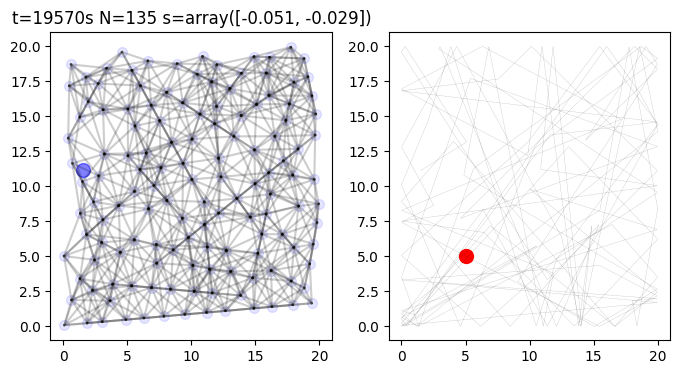

In [3]:
p = [5, 5]

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(*np.array(space.get_position()).T, s=100, color="blue", alpha=0.5)
plt.scatter(*np.array(space.get_centers()).T, s=50, color="blue", alpha=0.1)
#plt.scatter(*p, s=100, c='r')
for edge in space.make_edges():
    plt.plot((edge[0][0], edge[1][0]), (edge[0][1], edge[1][1]),
                                  alpha=0.1, color="black")


plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.title(f"t={t}s N={len(space)} {s=}")

plt.subplot(122)
plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.2)
plt.scatter(*p, s=100, c='r')
plt.xlim((-1, size+1))
plt.ylim((-1, size+1))
plt.show()

In [4]:
conn = space.get_connectivity()

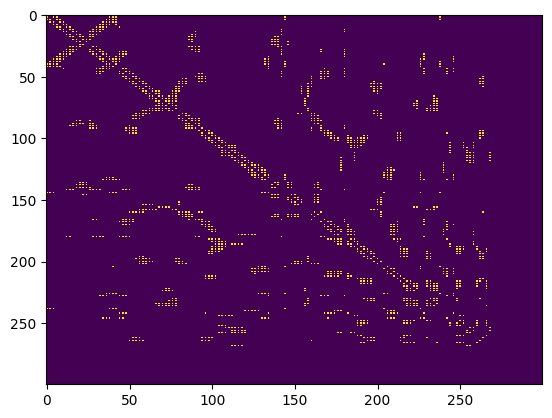

In [17]:
plt.imshow(conn, interpolation="nearest", aspect="auto");

In [12]:
conn[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## GC plot

In [180]:
N = 300

gc = pclib.GridLayerSq(sigma=0.01, speed=0.5, bounds=[-1, 1, -1, 1])

# random walk
speed = 0.08
size = 10.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 331583.62it/s]
2025-02-18 17:15:59 | 


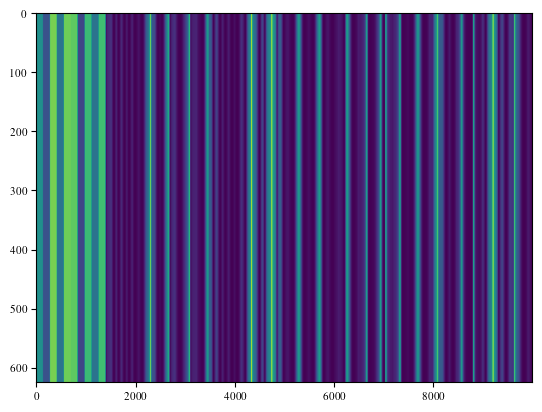

In [92]:
brain.get

In [54]:
colrs = plt.cm.rainbow(len(activity))

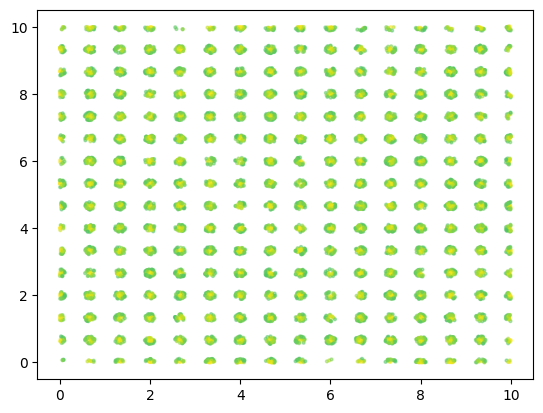

In [155]:
asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=asum, s=np.where(asum>0.02, 4, 0), alpha=0.5);


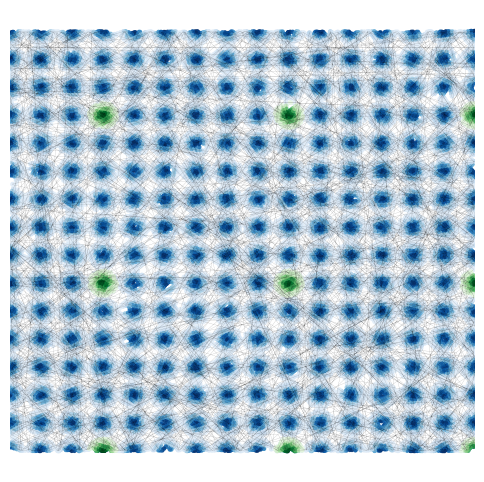

In [182]:
fig = plt.figure(figsize=(6, 6))
plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
            s=np.where(activity[:, :].sum(axis=0)>0.1, 5, 0),
            alpha=0.9, cmap="Blues")
plt.scatter(*np.array(points[1:]).T, c=activity[3, :], 
            s=np.where(activity[3, :]>0.1, 5, 0),
            alpha=0.9, cmap="Greens")

plt.axis("off")
plt.xlim((0, size))
plt.xlim((0, size))

#plt.title("Grid cell layer")

plt.show()

### hex

In [19]:

gc = pclib.GridLayerHex(sigma=0.04, speed=0.6)

# random walk
speed = 0.08
size = 20.

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 200_000

# record
activity = np.zeros((len(gc), tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = gc([points[-1][0]-old_point[0],
                         points[-1][1]-old_point[1]])
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [00:00<00:00, 394556.01it/s]
2025-02-17 20:55:41 | 


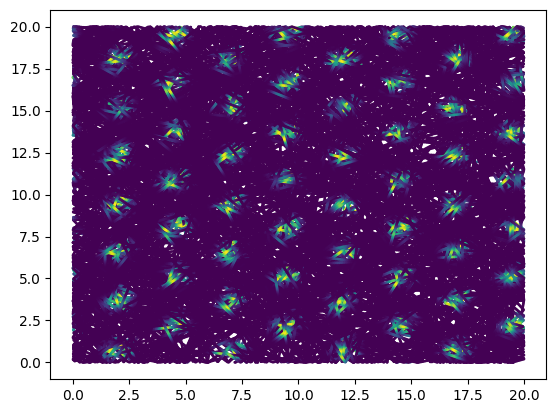

In [28]:
#asum = activity[:, :].mean(axis=0)
plt.scatter(*np.array(points[1:]).T, c=activity[0], s=1, alpha=1.)
plt.show()


### pcnn

100%|███████████████████████████████████████████████| 100000/100000 [13:39<00:00, 122.03it/s]
2025-02-18 03:47:11 | 


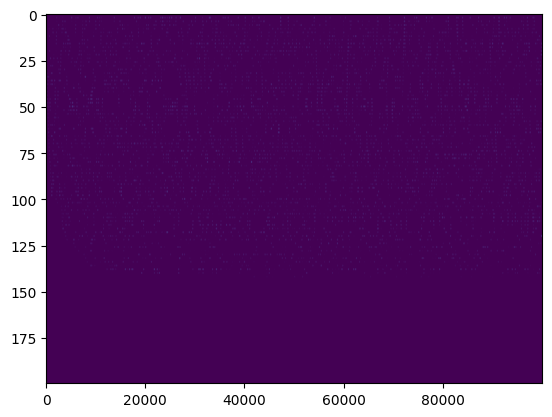

In [165]:
N = 200

local_scale = 0.02
gcn = pclib.GridNetworkSq([
            pclib.GridLayerSq(sigma=0.04, speed=1.*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.8*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.7*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.5*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.3*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.2*local_scale),
            pclib.GridLayerSq(sigma=0.04, speed=0.1*local_scale)])

pcnn = pclib.PCNN(N=N,
                  Nj=len(gcn),
                  gain=10.0,
                  offset=1.1,
                  clip_min=0.01,
                  threshold=0.3,
                  rep_threshold=0.9,
                  rec_threshold=1.0,
                  min_rep_threshold=0.99,
                  xfilter=gcn,
                  tau_trace=2.0,
                  name="2D")

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=N,
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])



# random walk
speed = 2.
size = 200

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 100_000

# record
activity = np.zeros((N, tot))
plotting = False

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= size:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    brain(s, 0., 0., False)
    activity[:, t] = brain.get_representation_fine()
    
    old_point = points[-1]

plt.imshow(activity[:, :], aspect="auto");
logger()

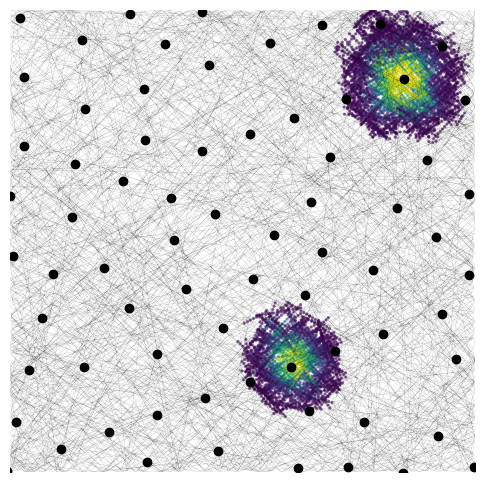

In [178]:
fig = plt.figure(figsize=(6, 6))
plt.plot(*np.array(points[1:]).T, "k-", lw=0.1, alpha=0.5)
#plt.scatter(*np.array(points[1:]).T, c=activity[:, :].sum(axis=0), 
#            s=np.where(activity[:, :].sum(axis=0)>0.01, 2, 0),
#            alpha=0.9, cmap="viridis")

# cell 1 
plt.scatter(*np.array(points[1:]).T, c=activity[12, :]+activity[50, :], 
            s=np.where((activity[12, :]+activity[50, :])>0.01, 2, 0.),
            alpha=0.5, cmap="viridis")

# cell 2
#plt.scatter(*np.array(points[1:]).T, c=activity[50, :], 
#            s=np.where(activity[50, :]>0.01, 2, 0.1),
#            alpha=0.7, cmap="viridis")


plt.scatter(*np.array(centers).T, color="black")
plt.xlim((0, size))
plt.ylim((0, size))
plt.axis("off")

#plt.title("Place cell layer")

plt.show()

In [168]:
centers = brain.get_space_fine_centers()

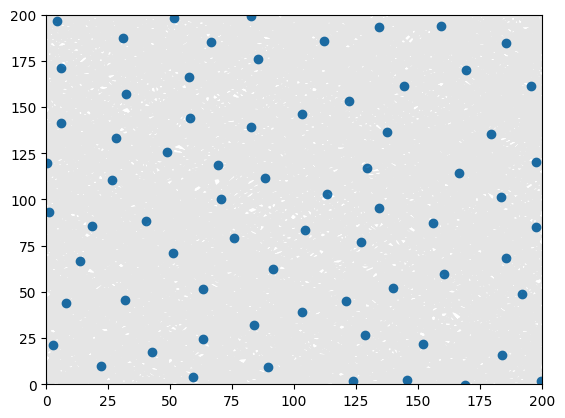

In [169]:
plt.plot(*np.array(points).T, "k-", alpha=0.1)
plt.scatter(*np.array(centers).T)
plt.xlim((0, size))
plt.ylim((0, size))
plt.show()

## Agent 

In [66]:
parameters = utc.load_parameters()

2025-03-24 00:27:45 | 
----
Loading from evolution
2025-03-24 00:27:45 | 
----
Loading from evolution
2025-03-24 00:27:45 | 
----
Loading from evolution
2025-03-24 00:27:45 | 
----
Loading from evolution


0: 1_best_agent.json
1: 2_best_agent.json
2: 3_best_agent.json
3: 4_best_agent.json
4: 5_best_agent.json
5: 6_best_agent.json
6: 7_best_agent.json
7: 8_best_agent.json
8: 9_best_agent.json
9: 10_best_agent.json
10: 11_best_agent.json
11: 12_best_agent.json
12: 13_best_agent.json
13: 14_best_agent.json
14: 15_best_agent.json
15: 16_best_agent.json
16: 17_best_agent.json
17: 18_best_agent.json
18: 19_best_agent.json
19: 20_best_agent.json
20: 21_best_agent.json
21: 22_best_agent.json
22: 23_best_agent.json
23: 24_best_agent.json
24: 25_best_agent.json
25: 26_best_agent.json
26: 27_best_agent.json
27: 28_best_agent.json
28: 29_best_agent.json
29: 30_best_agent.json
30: 31_best_agent.json
31: 32_best_agent.json
32: 33_best_agent.json
33: 34_best_agent.json
34: 35_best_agent.json
35: 36_best_agent.json
36: 37_best_agent.json
37: 38_best_agent.json
38: 39_best_agent.json
39: 40_best_agent.json
40: 41_best_agent.json
41: 42_best_agent.json
42: 43_best_agent.json
43: 44_best_agent.json
44: 45_


>Select file:  53


2025-03-24 00:27:47 | Loaded 54_best_agent.json
2025-03-24 00:27:47 | Loaded 54_best_agent.json
2025-03-24 00:27:47 | Loaded 54_best_agent.json
2025-03-24 00:27:47 | Loaded 54_best_agent.json
2025-03-24 00:27:47 | Agent fitness=79.000
2025-03-24 00:27:47 | Agent fitness=79.000
2025-03-24 00:27:47 | Agent fitness=79.000
2025-03-24 00:27:47 | Agent fitness=79.000
2025-03-24 00:27:47 | Agent fitness={'gain_fine': 33.0, 'offset_fine': 1.0, 'threshold_fine': 0.4, 'rep_threshold_fine': 0.86, 'rec_threshold_fine': 43, 'tau_trace_fine': 140, 'remap_tag_frequency': 3, 'num_neighbors': 13, 'min_rep_threshold': 0.77, 'gain_coarse': 16.6, 'offset_coarse': 1.0, 'threshold_coarse': 0.4, 'rep_threshold_coarse': 0.76, 'rec_threshold_coarse': 41, 'tau_trace_coarse': 24, 'lr_da': 0.99, 'lr_pred': 0.3, 'threshold_da': 0.04, 'tau_v_da': 2.0, 'lr_bnd': 0.6, 'threshold_bnd': 0.3, 'tau_v_bnd': 4.0, 'tau_ssry': 437.0, 'threshold_ssry': 0.986, 'threshold_circuit': 0.9, 'remapping_flag': 8, 'rwd_weight': 2.96, 

In [61]:
with open("cache/54_best_agent.json", "r") as f:
    sess = json.load(f)

In [62]:
sess.keys()

dict_keys(['info', 'genome'])

In [63]:
sess['info']['other']

'remapping, 0 0 1 1'

In [57]:
parameters

{'gain_fine': 33.0,
 'offset_fine': 1.0,
 'threshold_fine': 0.4,
 'rep_threshold_fine': 0.86,
 'rec_threshold_fine': 43,
 'tau_trace_fine': 140,
 'remap_tag_frequency': 3,
 'num_neighbors': 13,
 'min_rep_threshold': 0.77,
 'gain_coarse': 16.6,
 'offset_coarse': 1.0,
 'threshold_coarse': 0.4,
 'rep_threshold_coarse': 0.76,
 'rec_threshold_coarse': 41,
 'tau_trace_coarse': 24,
 'lr_da': 0.99,
 'lr_pred': 0.3,
 'threshold_da': 0.04,
 'tau_v_da': 2.0,
 'lr_bnd': 0.6,
 'threshold_bnd': 0.3,
 'tau_v_bnd': 4.0,
 'tau_ssry': 437.0,
 'threshold_ssry': 0.986,
 'threshold_circuit': 0.9,
 'remapping_flag': 8,
 'rwd_weight': 2.96,
 'rwd_sigma': 33.6,
 'col_weight': 0.06,
 'col_sigma': 20.6,
 'rwd_field_mod_fine': 0.0,
 'rwd_field_mod_coarse': 0.6,
 'col_field_mod_fine': -0.6,
 'col_field_mod_coarse': 1.8,
 'action_delay': 120.0,
 'edge_route_interval': 5,
 'forced_duration': 1,
 'fine_tuning_min_duration': 32}

In [100]:
remap_tag_frequency = parameters["remap_tag_frequency"] if "remap_tag_frequency" in parameters else 200
remapping_flag = parameters["remapping_flag"] if "remapping_flag" in parameters else 0
lr_pred = parameters["lr_pred"] if "lr_pred" in parameters else 0.2

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=global_parameters["N"],
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            num_neighbors=parameters["num_neighbors"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            remap_tag_frequency=remap_tag_frequency,
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            lr_pred=lr_pred,
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            remapping_flag=remapping_flag,
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            rwd_field_mod_fine=parameters["rwd_field_mod_fine"],
            rwd_field_mod_coarse=parameters["rwd_field_mod_coarse"],
            col_field_mod_fine=parameters["col_field_mod_fine"],
            col_field_mod_coarse=parameters["col_field_mod_coarse"],
            action_delay=parameters["action_delay"], # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])

logger(brain)

2025-03-23 00:39:39 | Brain


In [101]:
""" make game environment """

verbose = False
verbose_min = True
game_settings["rendering"] = False
reward_settings["silent_duration"] = 5_000
game_settings["max_duration"] = 100_000

#room_name = "Hallway.00"
room_name = "Flat.0000"
#room_name = "Hole.v0"

if verbose and verbose_min:
    logger(f"room_name={room_name}")

room = make_room(name=room_name,
                       thickness=game_settings["room_thickness"],
                       bounds=[0, 1, 0, 1])
room_bounds = [room.bounds[0]+10, room.bounds[2]-10,
               room.bounds[1]+10, room.bounds[3]-10]

# ===| objects |===


possible_positions = room.get_room_positions()

rw_position_idx = np.random.randint(0, len(possible_positions))
rw_position = possible_positions [rw_position_idx]
agent_possible_positions = possible_positions.copy()
agent_position = agent_possible_positions[np.random.randint(0,
                                            len(agent_possible_positions))]
rw_tau = reward_settings["tau"] if "tau" in reward_settings else 400
if "move_threlshold" in reward_settings:
    rw_move_threshold = reward_settings["move_threshold"]
else:
    rw_move_threshold = 2

# --- objects
reward_obj = objects.RewardObj(
            # position=reward_settings["rw_position"],
            position=rw_position,
            possible_positions=possible_positions,
            radius=reward_settings["rw_radius"],
            sigma=reward_settings["rw_sigma"],
            fetching=reward_settings["rw_fetching"],
            value=reward_settings["rw_value"],
            bounds=room_bounds,
            delay=reward_settings["delay"],
            silent_duration=reward_settings["silent_duration"],
            fetching_duration=reward_settings["fetching_duration"],
            use_sprites=global_parameters["use_sprites"],
            tau=rw_tau,
            move_threshold=rw_move_threshold,
            transparent=reward_settings["transparent"])

body = objects.AgentBody(
            position=agent_position,
            speed=global_parameters["speed"],
            possible_positions=agent_possible_positions,
            bounds=game_settings["agent_bounds"],
            use_sprites=global_parameters["use_sprites"],
            room=room,
            limit_position_len=1,
            color=(10, 10, 10))

logger(reward_obj)

duration = game_settings["max_duration"]

# --- envs

env = Environment(room=room,
                  agent=body,
                  reward_obj=reward_obj,
                  duration=game_settings["max_duration"],
                  rw_event=game_settings["rw_event"],
                  verbose=False,
                  visualize=game_settings["rendering"])
logger(env)


""" run game """

# if game_settings["rendering"]:
#     renderer = Renderer(elements=[brain.get_da(), brain.get_bnd()],
#                         space=brain.get_space_fine(),
#                         space_coarse=brain.get_space_coarse(),
#                         brain=brain, colors=["Greens", "Blues"],
#                         names=["DA", "BND"])
# else:
#     renderer = None

if verbose_min:
    logger("[@simulations.py]")
record = sim.run_game(env=env,
         brain=brain,
         renderer=None,
         plot_interval=game_settings["plot_interval"],
         pause=-1,
         record_flag=True,
         verbose=verbose,
         verbose_min=verbose_min)

if verbose_min:
    logger(f"rw_count={env.rw_count}")


2025-03-23 00:39:46 | Reward(150.0, 150.0, silent=5000, probabilistic, transparency=False)
2025-03-23 00:39:46 | Environment(Room(Flat.0000), duration=100000, verbose=False)
2025-03-23 00:39:46 | [@simulations.py]


KeyboardInterrupt: 

**General Plotting**

In [8]:
def get_t(a):
    for t, v in enumerate(a):
        if v > 0.01:
            return t
    return -1

In [83]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

bac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_bnd_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    bac[st:] += activity_fine[st:, i]

dac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_da_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    dac[st:] += activity_fine[st:, i]

100%|█████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 170550.26it/s]


In [84]:
""" activity """
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

In [85]:
""" skewed pc """
gidx = np.where(brain.get_gain_coarse()<brain.get_gain_coarse().mean()*0.9)[0]
gidx_r = np.where(brain.get_gain_coarse()>brain.get_gain_coarse().mean()*0.9)[0]
gidx

array([138, 162, 180, 204, 292, 390, 412, 432, 526, 528, 548, 556, 580])

In [86]:
""" bounds """
boundsx = (-300, 200)
boundsy = (-450, 250)
off_bnd = [150, 470]
off_da = [150, 150]

#### plotting

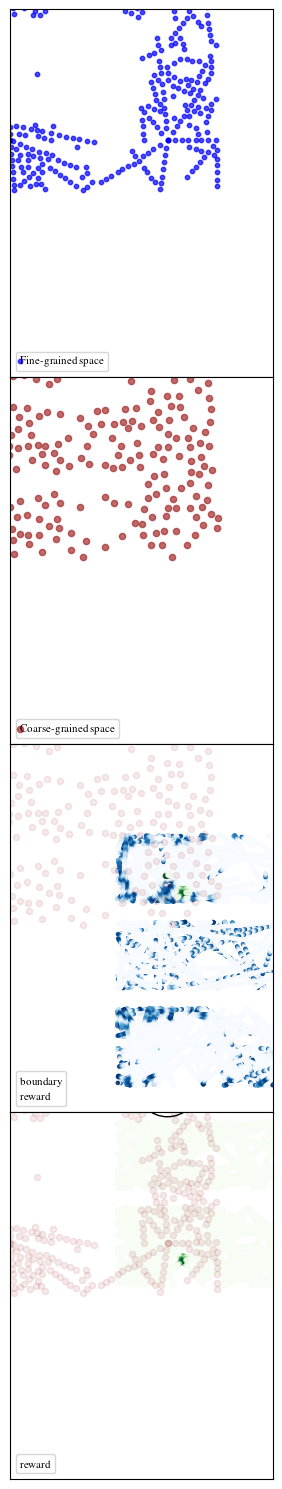

In [163]:
fig, axs = plt.subplots(4, 1, figsize=(4, 15))
fig.set_tight_layout({"h_pad": -0})


axs = axs.flatten()

# -- space plots --
axs[0].clear()
axs[1].clear()


# -- fine space
axs[0].scatter(*np.array(brain.get_space_fine_centers()).T,
                       color="blue", s=10, alpha=0.7,
              label="Fine-grained space")

# -- fine space
# axs[0, 0].set_title(f"#PCs={brain.get_space_fine_count()}")
#axs[0].set_title(f"Fine-grained space")

axs[0].set_xlim(boundsx)
axs[0].set_ylim(boundsy)
axs[0].set_aspect('equal', adjustable='box')
axs[0].grid(alpha=0.1)
axs[0].legend(loc="lower left", handlelength=0, handletextpad=0)

axs[0].set_xticks(())
axs[0].set_yticks(())

# -- coarse space
# axs[0, 1].set_title(f"#PCs={brain.get_space_coarse_count()}")

#for edge in brain.make_space_coarse_edges():
#    axs[1].plot((edge[0][0], edge[1][0]), (edge[0][1], edge[1][1]),
#                    alpha=0.1, lw=0.5, color="black")
3
axs[1].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.7,
              label="Coarse-grained space")

axs[1].set_xlim(boundsx)
axs[1].set_ylim(boundsy)
axs[1].set_xticks(())
axs[1].set_yticks(())
axs[1].set_aspect('equal', adjustable='box')
axs[1].grid(alpha=0.1)
axs[1].legend(loc="lower left", handlelength=0, handletextpad=0)


# -- BND
axs[2].clear()
axs[2].scatter(*trajectory.T-np.array(off_bnd).reshape(-1, 1),
                  c=bac, cmap="Blues", s=np.where(dac>-1, 5, 0),
               alpha=0.9, vmin=0, vmax=0.5,
              label="boundary")
axs[2].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.1)

axs[2].scatter(*trajectory.T-np.array(off_da).reshape(-1, 1),
                  c=dac, cmap="Greens", 
               s=np.where(dac>0, 10, 0), alpha=0.9, 
               vmin=0, vmax=0.5,
              label="reward")

axs[2].scatter(*np.array(brain.get_space_coarse_centers()).T,
                       color="brown", s=20, alpha=0.)
axs[2].set_xlim(boundsx)
axs[2].set_ylim(boundsy)
axs[2].set_xticks(())
axs[2].set_yticks(())
#axs[2].set_title(f"BND")
axs[2].set_aspect('equal', adjustable='box')
axs[2].legend(loc="lower left", handlelength=0, handletextpad=0)


# -- DA
axs[3].clear()
axs[3].scatter(*trajectory.T-np.array(off_da).reshape(-1, 1),
                  c=dac, cmap="Greens", 
               s=np.where(dac>-10, 10, 0), alpha=0.9, 
               vmin=0, vmax=0.5,
              label="reward")
axs[3].scatter(*np.array(brain.get_space_fine_centers()).T,
                       color="brown", s=20, alpha=0.1)

daw = brain.get_da_weights()
axs[3].scatter(*np.array(brain.get_space_fine_centers()).T,
                       c=daw,
                       s=np.where(daw > 0.01, 20, 1),
                       cmap="Greens", alpha=0.,
                       vmin=0., vmax=0.2)
circle = Circle(reward_obj.position-np.array(off_da),
                reward_obj.radius, edgecolor='black', facecolor='none')
axs[3].add_patch(circle)

axs[3].set_xlim(boundsx)
axs[3].set_ylim(boundsy)
axs[3].set_xticks(())
axs[3].set_yticks(())
#axs[3].set_title(f"DA")
axs[3].legend(loc="lower left", handlelength=0, handletextpad=0)
axs[3].set_aspect('equal', adjustable='box')

plt.show()


In [59]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

bac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_bnd_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    bac[st:] += activity_fine[st:, i]

dac = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    if brain.get_da_weights()[i] < 0.0001: continue
    st = get_t(activity_fine[:, i])
    dac[st:] += activity_fine[st:, i]

100%|███████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 103279.16it/s]


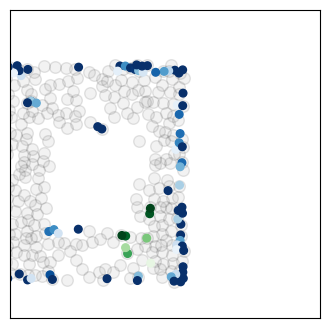

In [43]:
fig = plt.figure(figsize=(4, 4))

cc = np.array(brain.get_space_fine_centers()).T

bx = (-355, 450)
by = (-475, 200)

#plt.scatter(*cc, s=30, alpha=0.2, edgecolor="black", facecolor="white")
#plt.scatter(*trajectory.T-np.array([[300], [280]]), c=ac, cmap="Reds", s=np.where(ac>-10, 10, 0), alpha=.2, vmin=0, vmax=0.5)
#plt.scatter(*trajectory.T-np.array([[150], [150]]), c=dac, cmap="Greens", s=np.where(dac>0, 10, 0), alpha=0.5, vmin=0, vmax=0.5)


plt.scatter(*np.array(brain.get_space_coarse_centers()).T, s=70, alpha=0.1, edgecolor="black", facecolor="grey")


plt.scatter(*cc, c=brain.get_bnd_weights(), s=np.where(brain.get_bnd_weights()>0.001, 30, 0),
            cmap="Blues", vmin=0., vmax=0.3)

plt.scatter(*cc, c=brain.get_da_weights(), s=np.where(brain.get_da_weights()>0.001, 30, 0),
            cmap="Greens", vmin=0., vmax=0.9)
#plt.title("Neuromodulation", fontsize=37, y=1.02)
plt.xticks(())
plt.yticks(())
plt.xlim(bx)
plt.ylim(by)

plt.show()

In [44]:
activity_fine = np.array(record["activity_fine"])
activity_coarse = np.array(record["activity_coarse"])
trajectory = np.array(record["trajectory"])

In [45]:
trajectory.shape

(39999, 2)

In [46]:
def get_t(a):
    for t, v in enumerate(a):
        if v > 0.01:
            return t
    return -1

get_t(activity_fine[:, 4])

500

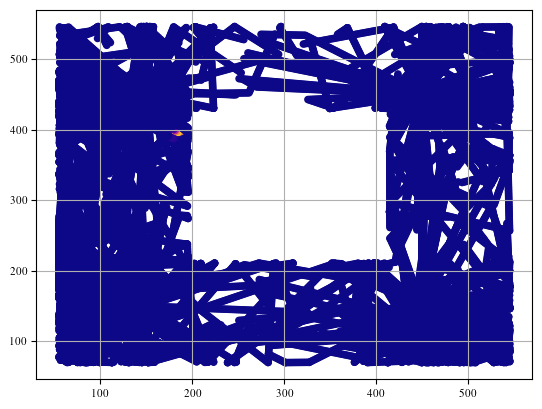

In [26]:
i = 50
st = get_t(activity_fine[:, i])
plt.scatter(*trajectory[st:].T, c=activity_fine[st:, i], cmap="plasma", s=np.where(activity_fine[st:, i]>-90.0, 20, 0))
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.grid()
plt.show()

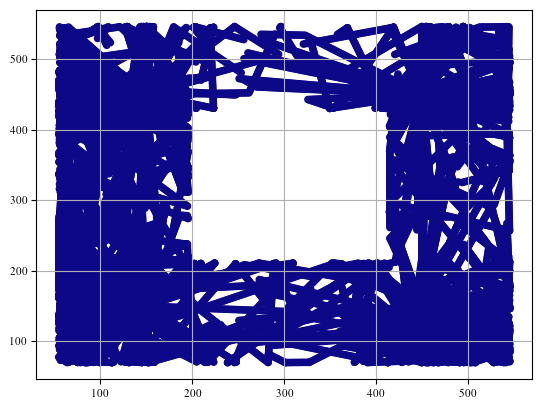

In [27]:
i = 34
st = get_t(activity_coarse[:, i])
plt.scatter(*trajectory[st:].T, c=activity_coarse[st:, i], cmap="plasma", s=np.where(activity_coarse[st:, i]>-90.0, 20, 0))
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.grid()
plt.show()

In [15]:
ac = np.zeros_like(activity_fine[:, 0])
ac1 = np.zeros_like(activity_fine[:, 0])

for i in tqdm(range(0, brain.get_space_fine_size(), 1)):
    st = get_t(activity_fine[:, i])
    ac[st:] += activity_fine[st:, i] * brain.get_bnd_weights()[i]
    ac1[st:] += activity_fine[st:, i] * (1-brain.get_bnd_weights()[i]>0.5)

100%|███████████████| 1024/1024 [00:16<00:00, 62.22it/s]


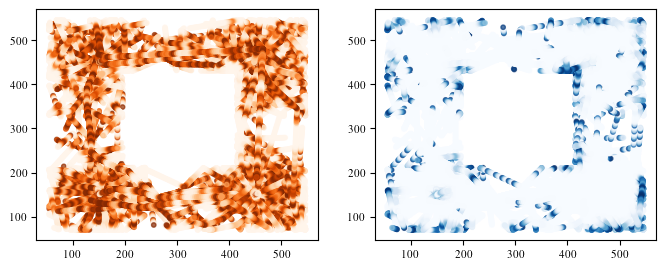

In [76]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(*trajectory.T, c=ac1, cmap="Oranges", 
            s=np.where(ac1>-10, 10, 0), alpha=.7, vmin=0, vmax=0.5)
plt.subplot(122)
plt.scatter(*trajectory.T, c=ac, cmap="Blues", 
            s=np.where(ac>-10, 10, 0), alpha=.7, vmin=0, vmax=0.5)
plt.show()

In [77]:
acc = np.zeros_like(activity_coarse[:, 0])

for i in tqdm(range(0, brain.get_space_coarse_size(), 1)):
    st = get_t(activity_coarse[:, i])
    acc[st:] += activity_coarse[st:, i]


100%|███████████████████████████| 625/625 [00:09<00:00, 65.80it/s]


In [78]:
acc.shape

(39999,)

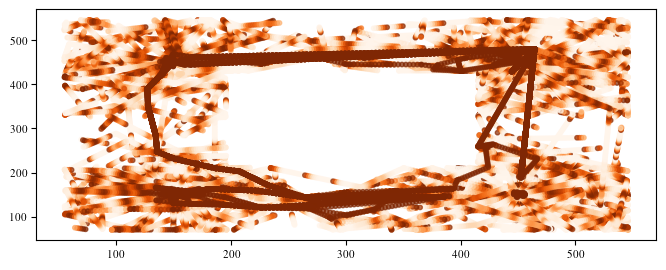

In [79]:
plt.figure(figsize=(8, 3))
plt.scatter(*trajectory.T, c=acc, cmap="Oranges", 
            s=np.where(acc>-10, 10, 0), alpha=.7, vmin=0, vmax=0.5)
plt.show()

In [29]:
cc = brain.get_space_coarse_centers()
cc.shape

(256, 2)

#### plotting 2

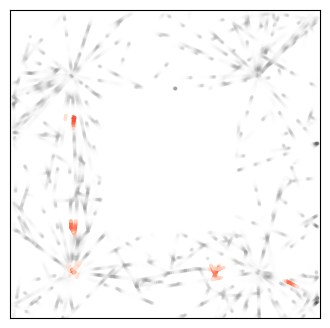

In [22]:
fig = plt.figure(figsize=(4, 4))

plt.scatter(*trajectory.T-np.array([[150], [450]]), c=activity_coarse[:, gidx_r].sum(axis=1), 
            cmap="Greys",
            s=np.where(activity_coarse[:, gidx_r].sum(axis=1)>0.0,
                       50/brain.get_gain_coarse()[gidx_r].mean(), 0),
            alpha=0.2, vmin=0, vmax=1.)

plt.scatter(*trajectory.T-np.array([[150], [450]]), c=activity_coarse[:, gidx].sum(axis=1), 
            cmap="Reds",
            s=np.where(activity_coarse[:, gidx].sum(axis=1)>0.1, 50/brain.get_gain_coarse()[gidx].mean(), 0),
            alpha=0.9, vmin=0, vmax=1.)

plt.xlim(-100, 400)
plt.ylim(-370, 100)
plt.xticks(())
plt.yticks(())
plt.show()

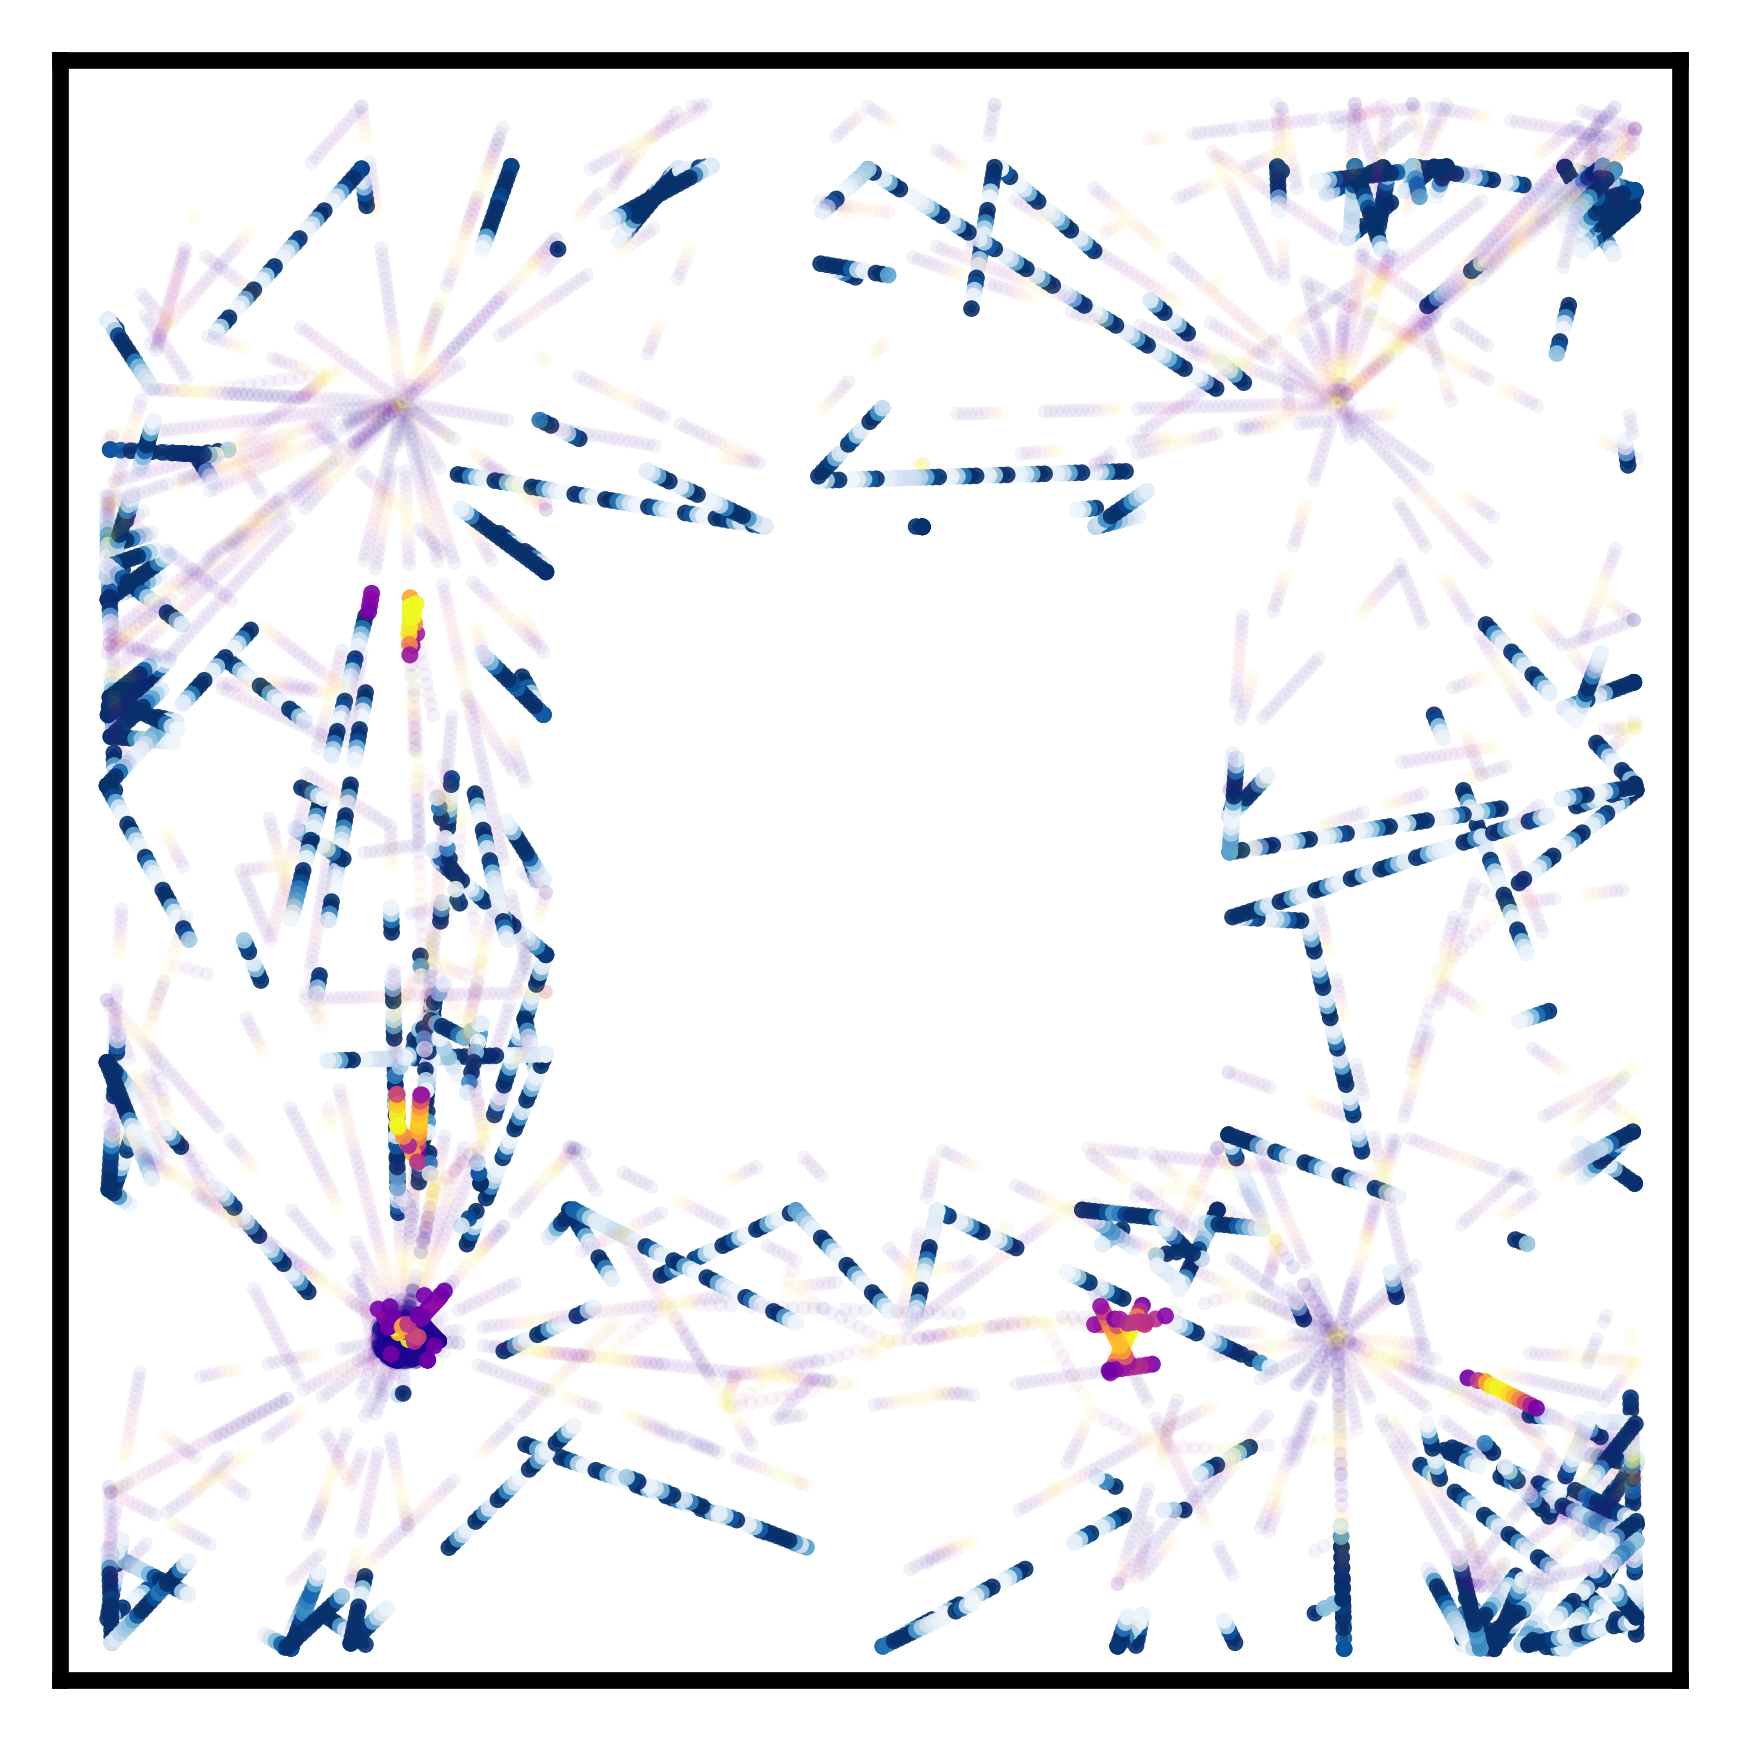

In [15]:
fig = plt.figure(figsize=(3, 3), dpi=600)

# Create axis with thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Thicker border lines
    
plt.scatter(*trajectory.T-np.array(off_bnd).reshape(-1, 1),
                  c=bac, cmap="Blues", s=np.where(bac>0., 1, 0),
               alpha=0.9, vmin=0., vmax=0.3,
              label="boundary")

# Original scatter plots with improved aesthetics
plt.scatter(*trajectory.T-np.array([[150], [450]]), 
            c=activity_coarse[:, gidx_r].sum(axis=1), 
            cmap="plasma",
            s=np.where(activity_coarse[:, gidx_r].sum(axis=1)>0.0,
                      50/brain.get_gain_coarse()[gidx_r].mean(), 0),
            alpha=0.05,  # Increased alpha for better visibility
            vmin=0, vmax=0.5,
            edgecolors='none')  # Remove point borders for cleaner look

plt.scatter(*trajectory.T-np.array([[150], [450]]), 
            c=activity_coarse[:, gidx].sum(axis=1), 
            cmap="plasma",
            s=np.where(activity_coarse[:, gidx].sum(axis=1)>0.1, 
                      50/brain.get_gain_coarse()[gidx].mean(), 0),
            alpha=0.9, 
            vmin=0, vmax=0.5,
            edgecolors='none')  # Remove point borders

# Set limits with a bit more padding
plt.xlim(-110, 410)
plt.ylim(-410, 110)

# Remove ticks but keep the thicker axes
plt.xticks([])
plt.yticks([])

# Add a light grid for reference (optional)
plt.grid(alpha=0.2, linestyle='--')

# Add tight layout for better use of figure space
plt.tight_layout()

# Show the plot
plt.show()

---

In [14]:
acgc = np.zeros_like(activity_coarse[:, 0])

for i in tqdm(range(0, brain.get_space_coarse_size(), 1)):
    if i not in gidx: continue 
    st = get_t(activity_coarse[:, i])
    acgc[st:] += activity_coarse[st:, i]


100%|██████████████| 625/625 [00:00<00:00, 40981.13it/s]


In [13]:
acgc = np.zeros_like(activity_coarse[:, 0])
acgc_r = np.zeros_like(activity_coarse[:, 0])
for i in gidx:
    st = get_t(activity_coarse[:, i])
    acgc[st:] += activity_coarse[st:, i]

for i in gidx_r:
    st = get_t(activity_coarse[:, i])
    acgc_r[st:] += activity_coarse[st:, i]
print(".")

.


In [12]:
gidx = np.where(brain.get_gain_coarse()<brain.get_gain_coarse().mean()*0.9)[0]
gidx_r = np.where(brain.get_gain_coarse()>brain.get_gain_coarse().mean()*0.9)[0]
#brain.get_gain_coarse()[gidx]
gidx

array([ 30,  32,  38,  40,  80, 298, 334, 368, 482])

In [129]:
brain.get_gain_fine().min()

21.6

In [29]:
acc = np.zeros_like(activity_coarse[:, 0])

for i in tqdm(range(0, brain.get_space_coarse_size(), 1)):
    st = get_t(activity_coarse[:, i])
    acc[st:] += activity_coarse[st:, i]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:14<00:00, 42.98it/s]


In [38]:
brain.get_space_coarse_count()

174

In [48]:
activity_coarse.shape

(39999, 256)

In [28]:
plt.scatter(*trajectory.T, c=ac, cmap="plasma", s=np.where(ac>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

NameError: name 'ac' is not defined

In [21]:
plt.scatter(*trajectory.T, c=acc, cmap="plasma", s=np.where(acc>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

NameError: name 'acc' is not defined

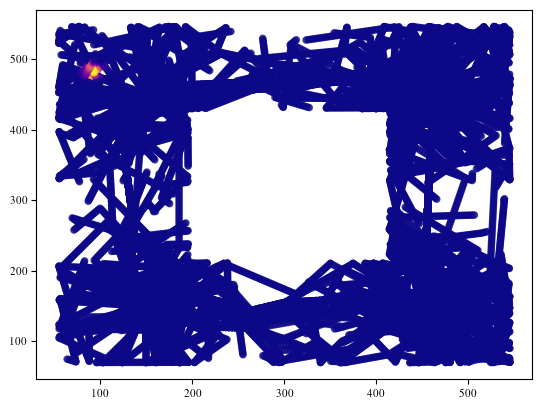

In [107]:
i = 30
plt.scatter(*trajectory.T, c=activity_coarse[:, i], cmap="plasma",
            s=np.where(activity_coarse[:, i]>-10, 20, 0), alpha=.7, vmin=0, vmax=0.5)
#plt.ylim((200, 350))
#plt.xlim((50, 550))
plt.show()

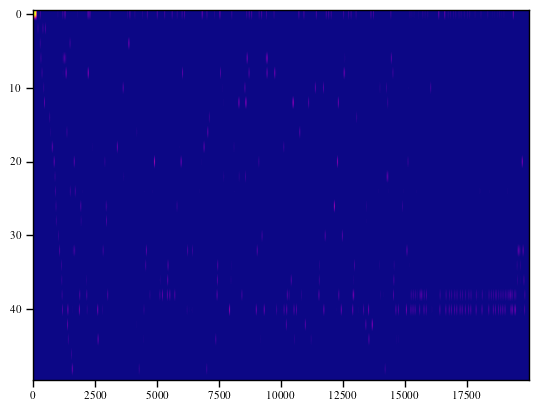

In [143]:
plt.imshow(activity_coarse.T[:50], cmap="plasma", aspect="auto");

#### plotting 3

In [87]:
trset = env.trajectory_set
len(trset)

86

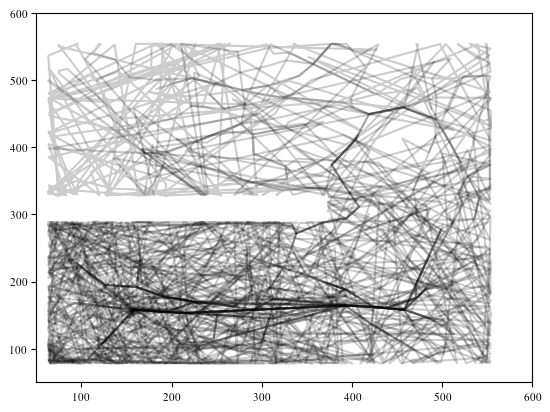

In [94]:
for tr in env.trajectory_set[40:]:
    plt.plot(*np.array(tr).T, 'k-', alpha=0.2)

plt.xlim((50, 600))
plt.ylim((50, 600))

plt.show()

In [24]:
k = 0

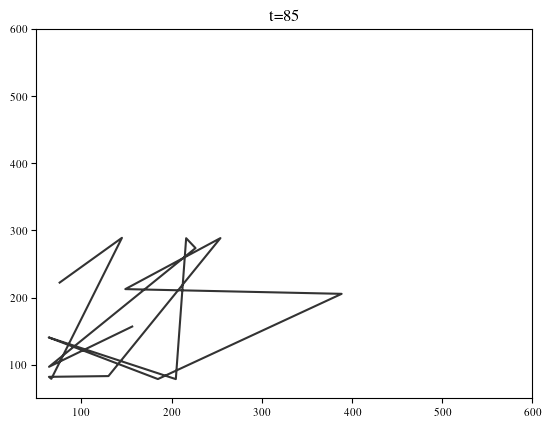

In [90]:
for t, tr in enumerate(env.trajectory_set):
    clear_output(wait=True)
    plt.plot(*np.array(tr).T, 'k-', alpha=0.8)
    
    plt.xlim((50, 600))
    plt.ylim((50, 600))
    plt.title(f"{t=}")
    plt.pause(0.1)

plt.show()

In [19]:
room.get_room_positions()

array([[150., 150.],
       [450., 450.],
       [150., 450.],
       [450., 150.]])

In [1]:
plt.plot(*np.array(env.trajectory).T, 'k-', alpha=0.2);

NameError: name 'plt' is not defined

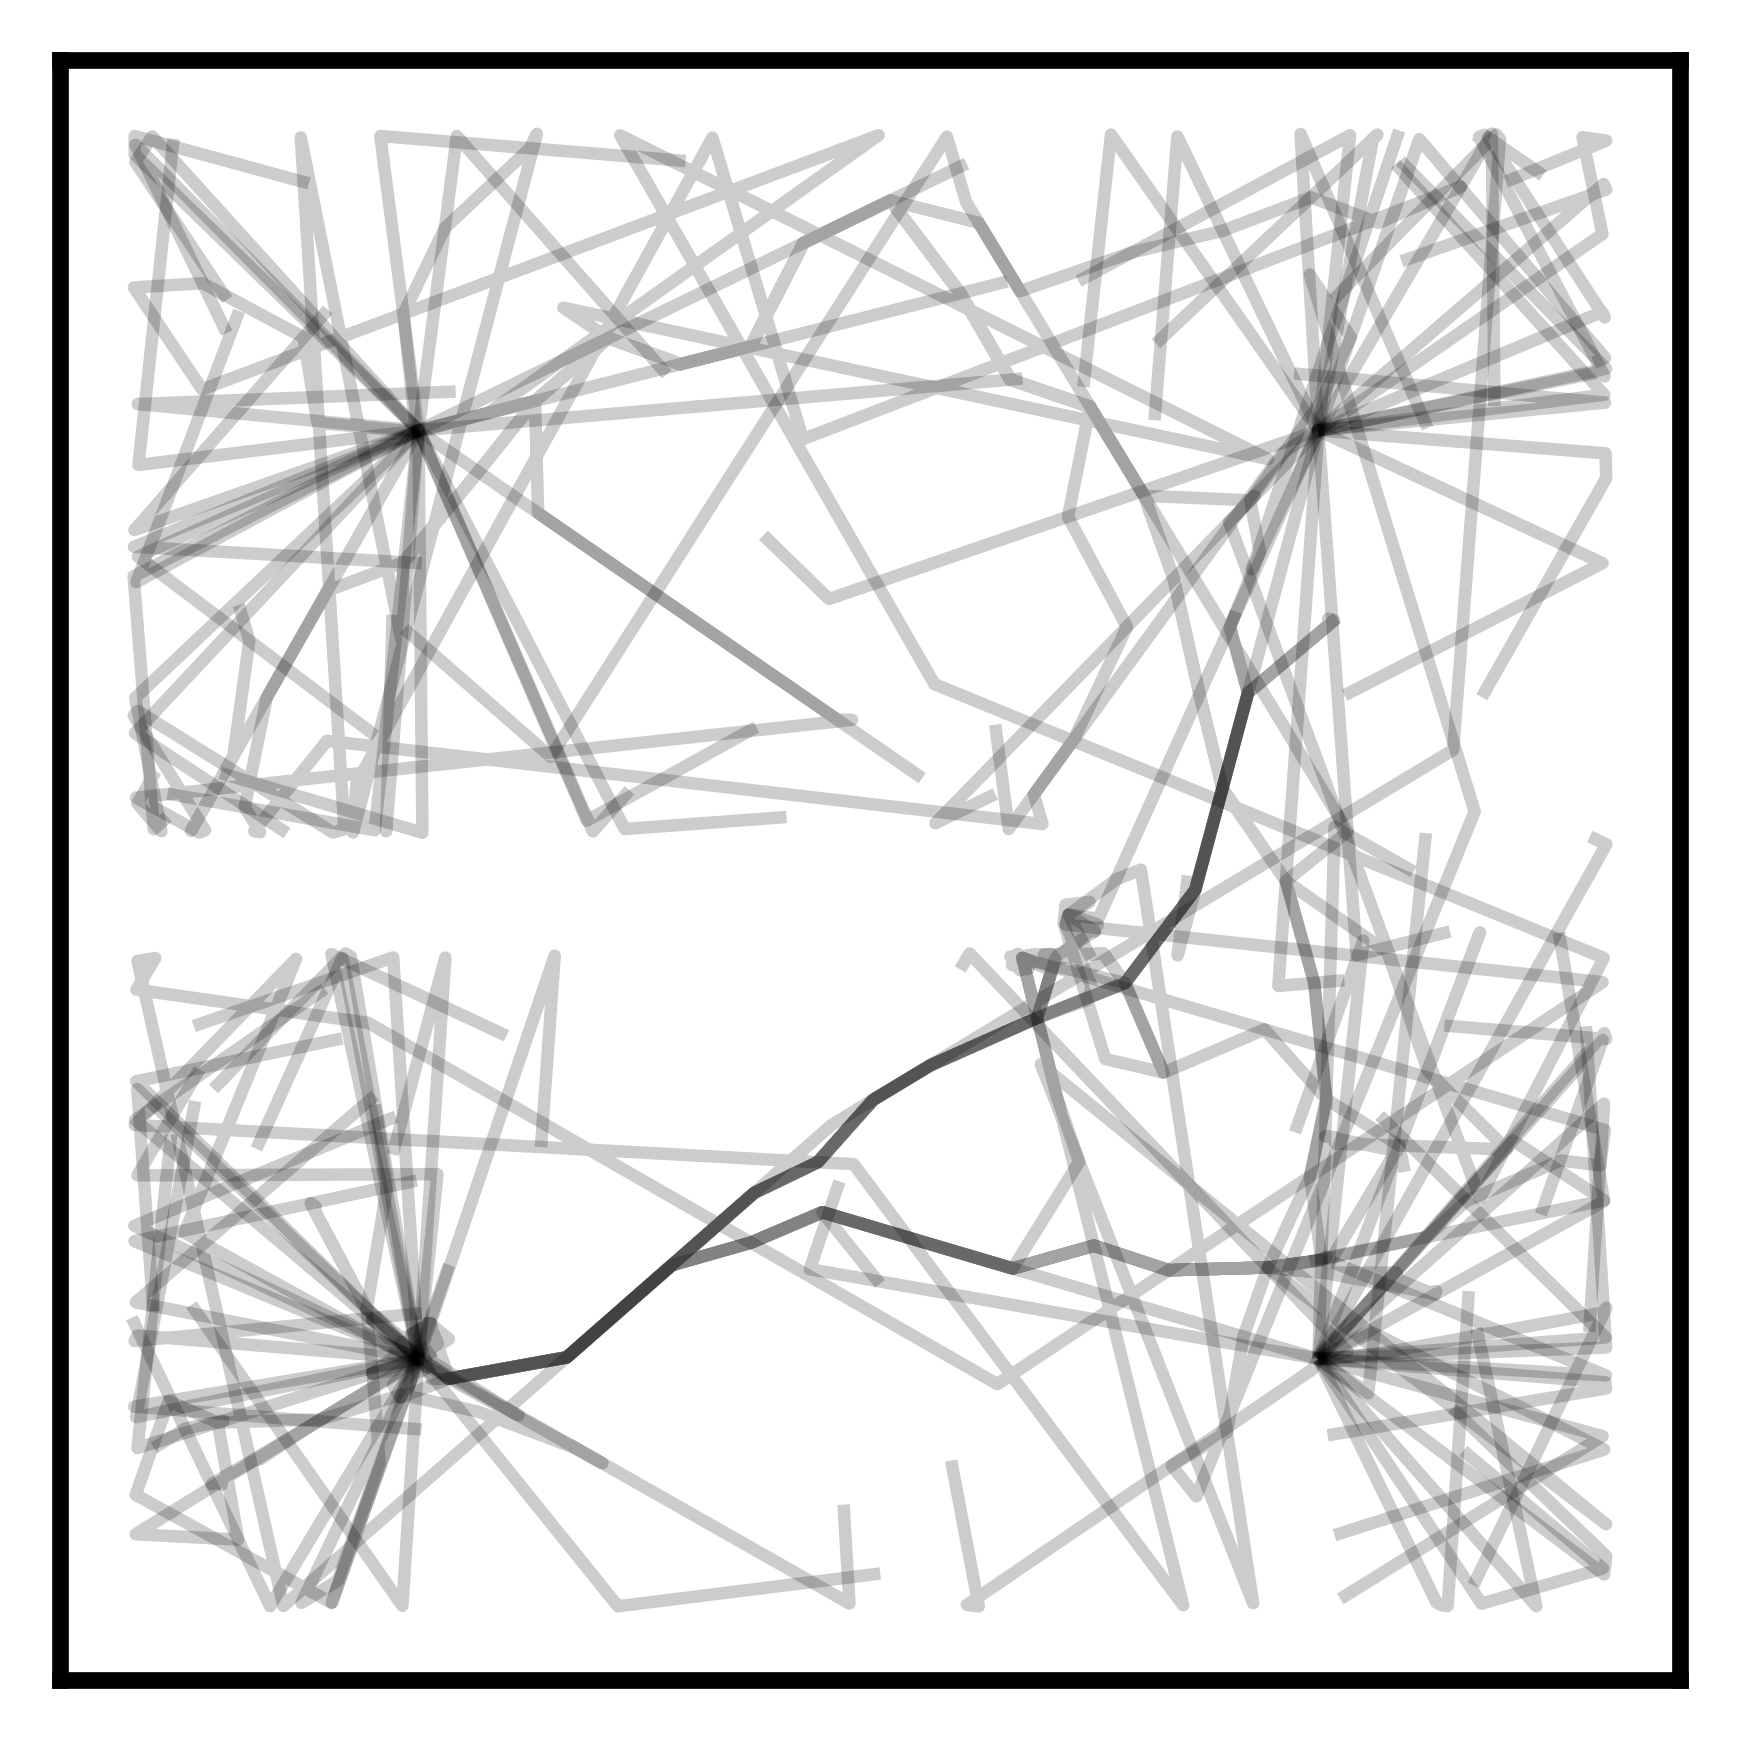

In [23]:
fig = plt.figure(figsize=(3, 3), dpi=600)

# Create axis with thicker borders
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)  # Thicker border lines
    
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T - np.array([50, 100]).reshape(-1, 1), 'k-', alpha=0.2)

# Set limits with a bit more padding
#plt.xlim(-110, 410)
#plt.ylim(-410, 110)

# Remove ticks but keep the thicker axes
plt.xticks([])
plt.yticks([])

# Add a light grid for reference (optional)
plt.grid(alpha=0.2, linestyle='--')

# Add tight layout for better use of figure space
plt.tight_layout()

# Show the plot
plt.show()

In [16]:
MPATH

'../media/plots'

In [17]:
os.getcwd()

'/Users/daniekru/Research/lab/PCNN/src'

#### pc fields

In [80]:
remap_tag_frequency = parameters["remap_tag_frequency"] if "remap_tag_frequency" in parameters else 200
remapping_flag = parameters["remapping_flag"] if "remapping_flag" in parameters else 0
lr_pred = parameters["lr_pred"] if "lr_pred" in parameters else 0.2

brain = pclib.Brain(
            local_scale_fine=global_parameters["local_scale_fine"],
            local_scale_coarse=global_parameters["local_scale_coarse"],
            N=global_parameters["N"],
            Nc=global_parameters["Nc"],
            min_rep_threshold=parameters["min_rep_threshold"],
            num_neighbors=parameters["num_neighbors"],
            rec_threshold_fine=parameters["rec_threshold_fine"],
            rec_threshold_coarse=parameters["rec_threshold_coarse"],
            speed=global_parameters["speed"],
            gain_fine=parameters["gain_fine"],
            offset_fine=parameters["offset_fine"],
            threshold_fine=parameters["threshold_fine"],
            rep_threshold_fine=parameters["rep_threshold_fine"],
            tau_trace_fine=parameters["tau_trace_fine"],
            remap_tag_frequency=remap_tag_frequency,
            gain_coarse=parameters["gain_coarse"],
            offset_coarse=parameters["offset_coarse"],
            threshold_coarse=parameters["threshold_coarse"],
            rep_threshold_coarse=parameters["rep_threshold_coarse"],
            tau_trace_coarse=parameters["tau_trace_coarse"],
            lr_da=parameters["lr_da"],
            lr_pred=lr_pred,
            threshold_da=parameters["threshold_da"],
            tau_v_da=parameters["tau_v_da"],
            lr_bnd=parameters["lr_bnd"],
            threshold_bnd=parameters["threshold_bnd"],
            tau_v_bnd=parameters["tau_v_bnd"],
            tau_ssry=parameters["tau_ssry"],
            threshold_ssry=parameters["threshold_ssry"],
            threshold_circuit=parameters["threshold_circuit"],
            remapping_flag=remapping_flag,
            rwd_weight=parameters["rwd_weight"],
            rwd_sigma=parameters["rwd_sigma"],
            col_weight=parameters["col_weight"],
            col_sigma=parameters["col_sigma"],
            rwd_field_mod_fine=parameters["rwd_field_mod_fine"],
            rwd_field_mod_coarse=parameters["rwd_field_mod_coarse"],
            col_field_mod_fine=parameters["col_field_mod_fine"],
            col_field_mod_coarse=parameters["col_field_mod_coarse"],
            action_delay=parameters["action_delay"],
            edge_route_interval=parameters["edge_route_interval"],
            forced_duration=parameters["forced_duration"],
            fine_tuning_min_duration=parameters["fine_tuning_min_duration"],
            min_weight_value=parameters["fine_tuning_min_duration"])

logger(brain)

2025-02-27 13:48:52 | Brain


In [81]:
N = brain.get_space_fine_size()

# random walk
speed = 1
size = 100.
sizey = 100

points = [[0., 0.]]

s = np.array([speed, speed])
x, y = points[0]
old_point = points[0]

tot = 10_000

# record
activity = np.zeros((N, tot))
plotting = 0

for t in tqdm(range(tot)):
    
    x += s[0]
    y += s[1]

    # hit wall
    if x <= 0 or x >= size:
        s[0] *= -1
        x += s[0]
    elif y <= 0 or y >= sizey:
        s[1] *= -1
        y += s[1]

    points += [[x, y]]
    if t % 500 == 0:
        s = np.random.uniform(-1, 1, 2)
        s = speed * s / np.abs(s).sum()
        s = np.around(s, 3)

    activity[:, t] = brain([points[-1][0]-old_point[0],
                            points[-1][1]-old_point[1]], 0., 0., False)[0]
    
    old_point = points[-1]

    if t % 100 == 0 and plotting:
        clear_output(wait=True)
        plt.figure(figsize=(4, 4))
        #plt.subplot(121)
        plt.plot(*np.array(points).T, 'k-', lw=0.3, alpha=0.3)
        
        #plt.scatter(*np.array(gc.get_positions()).T, s=50, color="blue")

        plt.title(f"{t=}")
        #plt.subplot(122)
        #plt.imshow(activity[:, t-500:t], cmap="plasma", aspect="auto")
        #plt.plot(range(len(activity)), len(activity) - activity*10, '-', color="white", lw=2)
        #plt.axis('off')
        
        plt.scatter(*points[-1], s=100, c='r')

        plt.xlim((-4, size+4))
        plt.ylim((-4, size+4))
        plt.pause(0.001)

logger()

100%|██████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 969.47it/s]
2025-02-27 13:49:05 | 


In [9]:
np.clip(activity[40, -100:], 0, 10)
plt.imshow(np.clip(activity, 0, 10), cmap="plasma")
plt.show()

NameError: name 'activity' is not defined

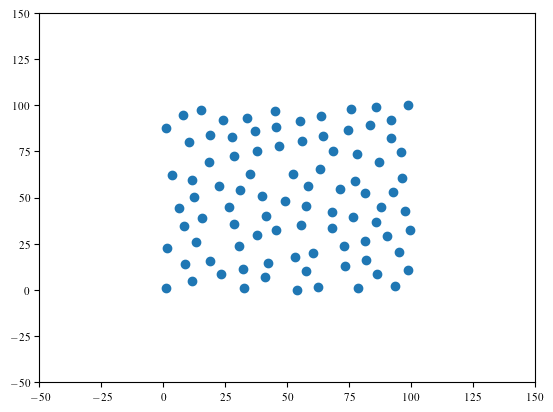

In [90]:
plt.scatter(*np.array(brain.get_space_fine_centers()).T)
plt.xlim((-50, 150))
plt.ylim((-50, 150))
plt.show()

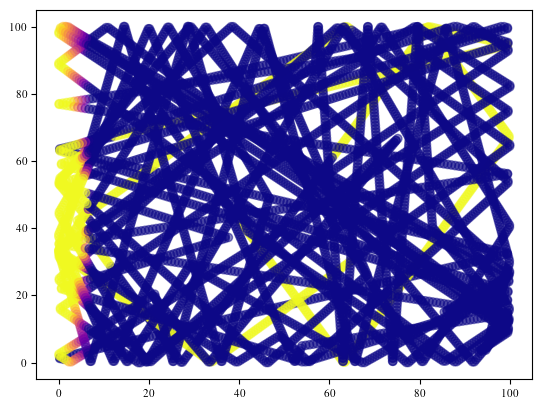

In [91]:
#asum = activity[:, :].mean(axis=0)
asum = np.clip(activity[40, :], 0, 10)
plt.scatter(*np.array(points[1:]).T, c=asum, alpha=0.5, cmap="plasma", vmin=0., vmax=0.4);


In [16]:
renderer.render()
plt.show()

In [79]:
brain.get_space_fine_count()

541

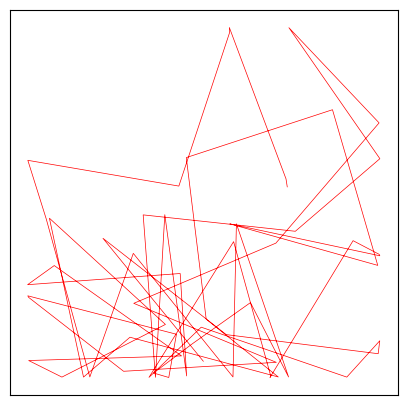

In [228]:
plt.figure(figsize=(5, 5))
for tr in env.trajectory_set:
    plt.plot(*np.array(tr).T, 'r-', lw=0.5)

plt.xticks(())
plt.yticks(())
plt.show()

In [108]:
brain.get_gain_coarse()

array([ 19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
        19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,  19.6 ,
      

## performance study

In [108]:
path = "analysis/results"
files = {i: f for i, f in enumerate(os.listdir(path)) if "performance_252_23" in f}

print(f"{files}")
ans = input("idx: ")
ans = int(ans) if ans != "" else list(files.keys())[0]
rpath = path + "/" + files[ans]
with open(rpath + "/metadata.json", "r") as fr:
    metadata = json.load(fr)
with open(rpath + "/data.json", "r") as fr:
    data = json.load(fr)

print("-"*50)
print(f"room={metadata['room']}")
print(f"result={np.mean(data):.1f}+-{np.std(data):.2f}")

{18: 'performance_252_2325', 20: 'performance_252_2313'}


idx:  18


--------------------------------------------------
room=Flat.1011
result=89.9+-36.56


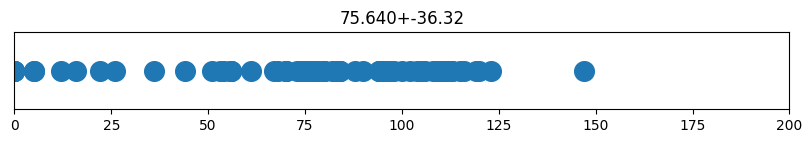

In [106]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

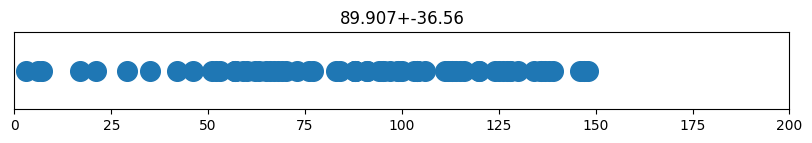

In [109]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

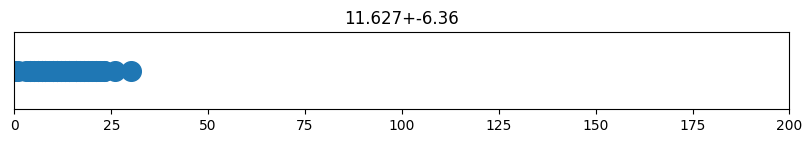

In [92]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 200))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

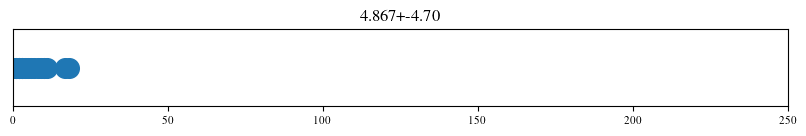

In [214]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

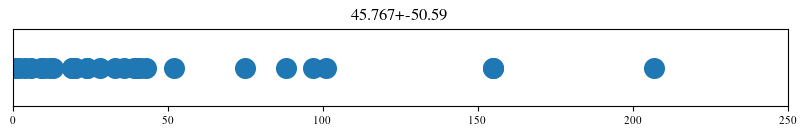

In [210]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

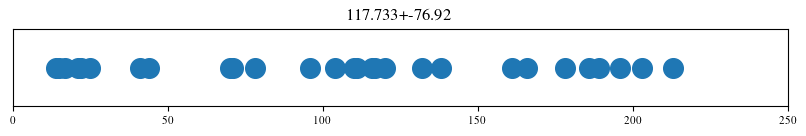

In [205]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [0]*len(data), s=200)
plt.yticks(())
plt.xlim((0, 250))
plt.title(f"{np.mean(data):.3f}+-{np.std(data):.2f}")
plt.show()

In [146]:
print(f"result={np.mean(data):.1f}+-{np.std(data):.2f}")

result=15.4+-15.60


## evolution study

In [179]:
evopath = os.getcwd() + "/cache/"
evolist = {i: f for i, f in enumerate(os.listdir(evopath)) if int(f.split("_")[0]) > 40}
logger(evolist)
with open(evopath + evolist[int(input("\nidx: "))], 'r') as f:
    evorun = json.load(f)

evo_data = evorun['info']['data']
logger(evorun['info']['date'])
logger(evorun['info']['evolution'])

2025-03-14 19:08:52 | {8: '48_best_agent.json', 9: '47_best_agent.json', 15: '50_best_agent.json', 16: '49_best_agent.json', 18: '46_best_agent.json', 23: '41_best_agent.json', 31: '44_best_agent.json', 33: '43_best_agent.json', 38: '42_best_agent.json', 49: '45_best_agent.json'}



idx:  15


2025-03-14 19:08:55 | 12/03/2025 at 17:21
2025-03-14 19:08:55 | {'NPOP': 128, 'NGEN': 100, 'CXPB': 0.6, 'MUTPB': 0.7, 'NLOG': 1, 'TARGET': [1.0], 'TARGET_ERROR': 0.0, 'NUM_CORES': 64, 'USE_TQDM': False}


In [100]:
evorun['info'].keys()

dict_keys(['date', 'model', 'game', 'evolution', 'evolved', 'data', 'other', 'performance', 'fitness_record', 'record_genome'])

In [101]:
evorun['info']['record_genome'].__len__()

230

In [84]:
evorun['info']['record_genome']['0'].keys()

dict_keys(['genome', 'fitness'])

In [181]:
def make_evo_params_dict(run) -> dict:

    names = run['info']['evolved']
    data = {name: [] for name in names}
    data['fitness'] = []
    for _, ind in run['info']['record_genome'].items():
        data['fitness'] += [ind['fitness']]
        for name in names:
            data[name] += [ind['genome'][name]]

    return data, names

In [180]:
evoparams, evonames = make_evo_params_dict(evorun)
num_params = len(evonames)

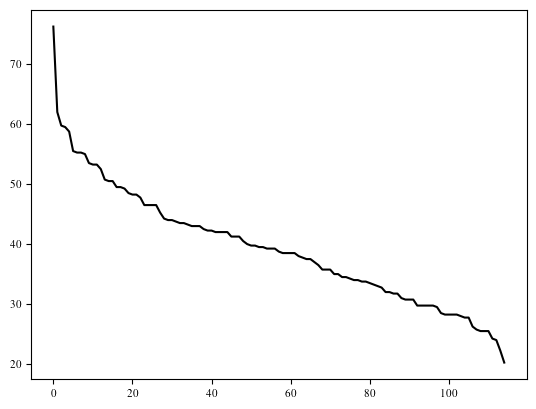

In [32]:
plt.plot(range(len(evoparams['fitness'])), evoparams['fitness'], 'k-');

In [89]:
evoparams['gain_fine'].__len__()

230

In [90]:
num_params // 2 + num_params % 2

11

In [91]:
len(evonames)

22

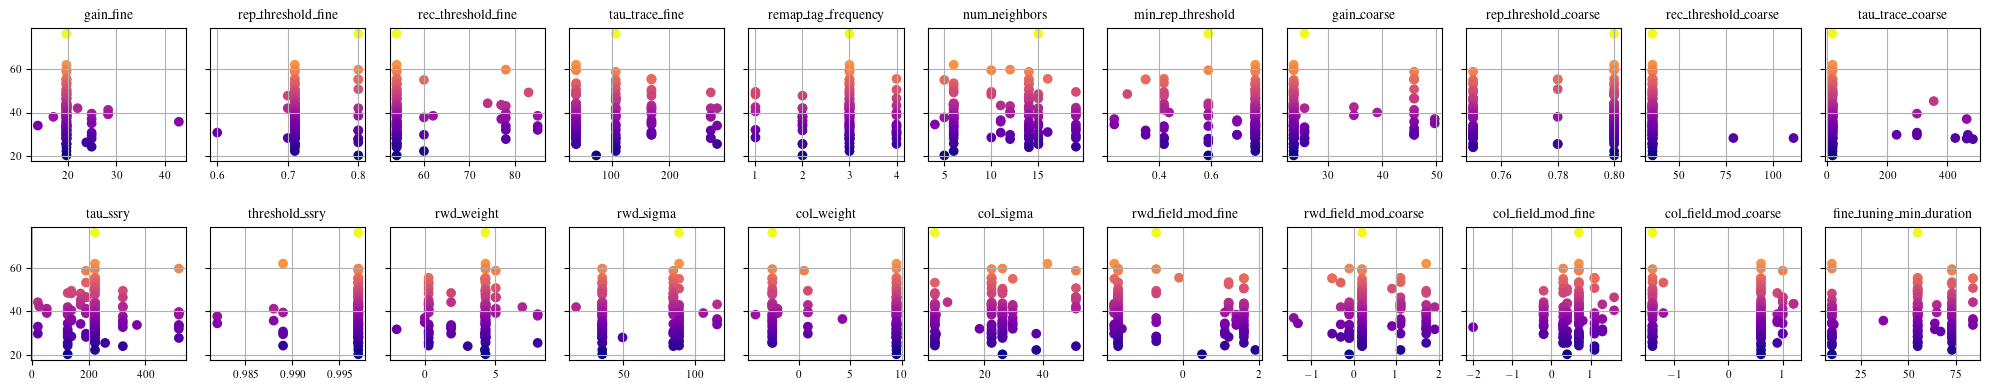

In [182]:
fig, axs = plt.subplots(2, num_params//2+num_params % 2,
                        figsize=(20, 4), sharey=True)
fig.set_tight_layout({'h_pad': 2})
axs = axs.flatten()
for i in range(len(evonames)):

    axs[i].scatter(evoparams[evonames[i]], evoparams['fitness'], c=evoparams['fitness'], cmap='plasma')
    #axs[i].scatter(evoparams[evonames[i]], evoparams['fitness'], c=evoparams['remap_tag_frequency'], cmap='Set1')

    axs[i].grid()
    #ax.axis("equal")
    axs[i].set_title(evonames[i], fontsize=10)

plt.show()

#### params plot

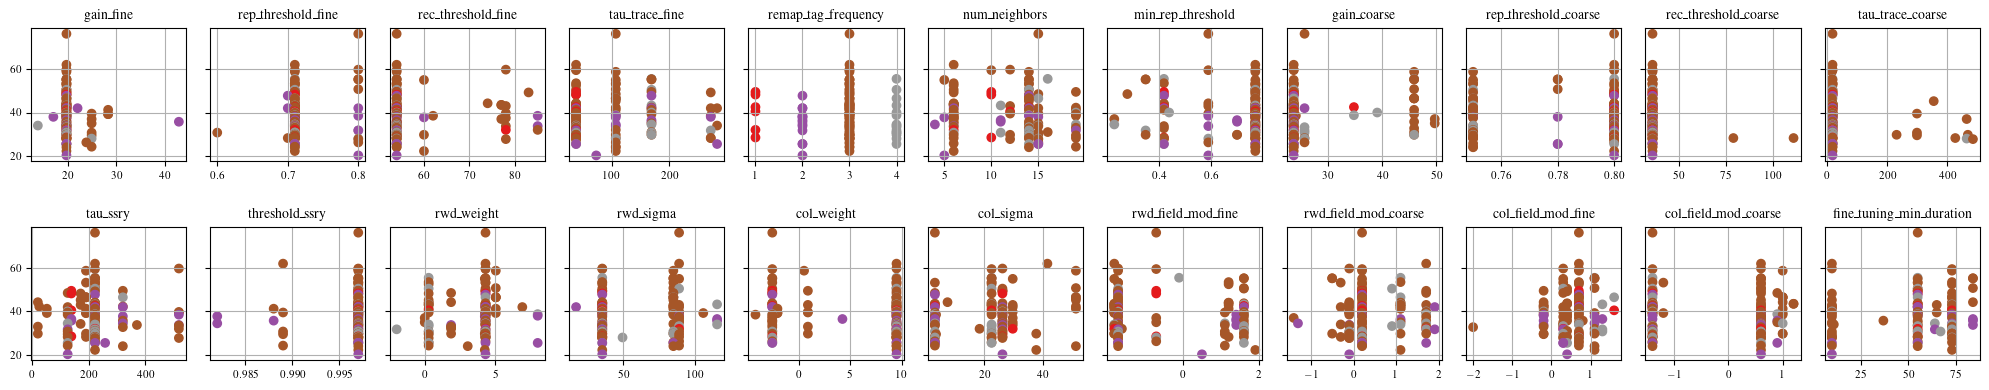

In [175]:

fig, axs = plt.subplots(2, num_params//2+num_params % 2,
                        figsize=(20, 4), sharey=True)
fig.set_tight_layout({'h_pad': 2})
axs = axs.flatten()
for i in range(len(evonames)):

    #axs[i].scatter(evoparams[evonames[i]], evoparams['fitness'], c=evoparams['fitness'], cmap='plasma')
    axs[i].scatter(evoparams[evonames[i]], evoparams['fitness'], c=evoparams['remap_tag_frequency'], cmap='Set1')

    axs[i].grid()
    #ax.axis("equal")
    axs[i].set_title(evonames[i], fontsize=10)

plt.show()

##### evolution plot

In [183]:
cutoff = 99
e_mean = np.array(evorun['info']['fitness_record']['mean'])[:cutoff] * 5 / 6
e_max = np.array(evorun['info']['fitness_record']['max'])[:cutoff] * 5 / 6
e_p16 = np.array(evorun['info']['fitness_record']['p16'])[:cutoff] * 5 / 6
e_p84 = np.array(evorun['info']['fitness_record']['p84'])[:cutoff] * 5 / 6

logger(f"performance: {evorun['info']['performance']}")
model_params = evorun['genome']
#model_params = {k: mean_genome[i] for i, k in enumerate(model_params)}
evorun['info'].keys(), model_params

2025-03-14 19:09:11 | performance: {'gen': '32', 'fitness': '[76.25]'}


(dict_keys(['date', 'model', 'game', 'evolution', 'evolved', 'data', 'other', 'performance', 'fitness_record', 'record_genome']),
 {'gain_fine': 19.7,
  'offset_fine': 1.0,
  'threshold_fine': 0.4,
  'rep_threshold_fine': 0.8,
  'rec_threshold_fine': 54,
  'tau_trace_fine': 107,
  'remap_tag_frequency': 3,
  'num_neighbors': 15,
  'min_rep_threshold': 0.59,
  'gain_coarse': 25.7,
  'offset_coarse': 1.0,
  'threshold_coarse': 0.4,
  'rep_threshold_coarse': 0.8,
  'rec_threshold_coarse': 36,
  'tau_trace_coarse': 18,
  'lr_da': 0.99,
  'lr_pred': 0.3,
  'threshold_da': 0.04,
  'tau_v_da': 2.0,
  'lr_bnd': 0.6,
  'threshold_bnd': 0.3,
  'tau_v_bnd': 4.0,
  'tau_ssry': 223.0,
  'threshold_ssry': 0.997,
  'threshold_circuit': 0.9,
  'remapping_flag': 2,
  'rwd_weight': 4.3,
  'rwd_sigma': 88.9,
  'col_weight': -2.55,
  'col_sigma': 3.2,
  'rwd_field_mod_fine': -0.7,
  'rwd_field_mod_coarse': 0.2,
  'col_field_mod_fine': 0.7,
  'col_field_mod_coarse': -1.4,
  'action_delay': 120.0,
  'edge_r

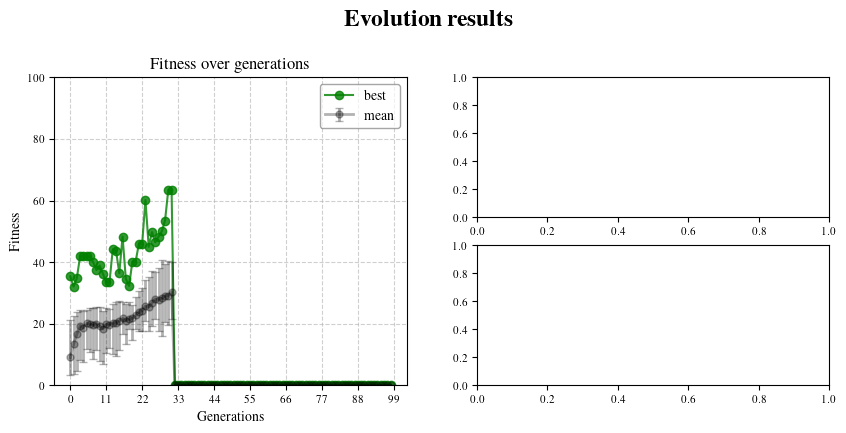

In [184]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

# Create figure with improved layout
fig = plt.figure(figsize=(10, 4))
fig.tight_layout()
gs = GridSpec(2, 2, figure=fig)

# Single plot in the first column (spans two rows)
ax = fig.add_subplot(gs[:, 0])

# Two plots in the second column
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

# Colorblind-friendly color palette
#colors = sns.color_palette("tab10", len(names))

xr = range(cutoff)

# ==============================================================
# === evolution

ax.plot(xr, e_max, '-o', color="green", alpha=0.8, label="best")

# p16 : array 
# p84 : array 

ax.errorbar(xr, 
            e_mean,
            yerr=[e_mean-e_p16, e_p84 - e_mean],
            fmt='-o', 
            color="black",
            label="mean",
            capsize=3,
            linewidth=2,
            alpha=0.3,
            markersize=5)

ax.legend(loc='best', 
          frameon=True, 
          fancybox=True, 
          framealpha=0.7, 
          edgecolor='gray')

ax.set_title(r'{Fitness over generations}')
ax.set_ylabel(r"Reward $R$")
ax.set_ylim((0, 100))

ax.set_xlabel(r"Generations")
ax.set_ylabel(r"Fitness")
ax.set_xticks(np.linspace(0, len(e_max), 10).astype(int))
ax.set_xticklabels(np.linspace(0, len(e_max), 10).astype(int))
ax.grid(alpha=0.6, linestyle='--')

# ==============================================================
# === function

# ==============================================================
# === activation functions


# ==============================================================
# === Overall figure title

fig.suptitle(r'\textbf{Evolution results}', 
             fontsize=17, y=1.05)

# Save with high DPI for publication
#plt.savefig('paper/figures/evolution_plot.png', dpi=500, bbox_inches='tight')
plt.show()

## performance plot

In [75]:
runpath = os.getcwd() + "/analysis/results/"
runlist = {i: f for i, f in enumerate(os.listdir(runpath)) if f.startswith("options_eval_243")}
logger(runlist)
runidx = input("idx: ")
runidx = tuple(runlist.keys())[-1] if runidx == "" else runidx
with open(runpath + runlist[int(runidx)], 'r') as f:
    run = json.load(f)


2025-03-24 13:51:14 | {9: 'options_eval_243_130.json', 11: 'options_eval_243_1345.json', 41: 'options_eval_243_227.json'}


idx:  11


In [25]:
data.shape

(2048, 5)

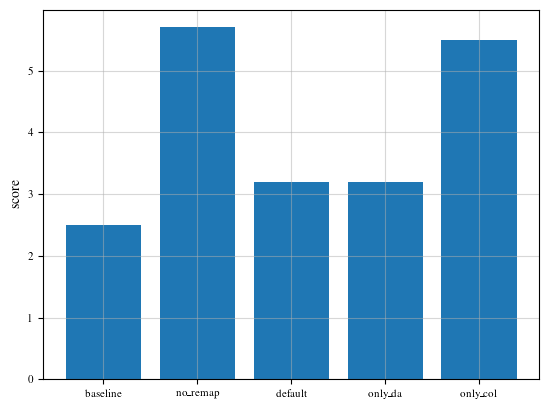

In [76]:
#plt.style.use('science')  # Requires matplotlib-style package
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Computer Modern Roman'],
    'text.usetex': True,
    'axes.labelsize': 10,
    'font.size': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8
})

data = np.array(run['results'])

plt.bar(range(5), data.mean(axis=0))
plt.xticks(range(5), run['options'])
plt.grid(alpha=0.5)
plt.ylabel("score")
plt.show()

In [69]:
data = np.array(run['results'])

In [27]:
data.shape

(2048, 5)

In [33]:
np.sort(data, axis=1)

array([[ 3.,  3.,  4.,  4.,  4.],
       [ 3.,  3.,  4.,  4.,  4.],
       [ 3.,  3.,  4.,  4.,  4.],
       ...,
       [14., 19., 49., 54., 76.],
       [15., 22., 51., 56., 93.],
       [17., 22., 71., 73., 96.]])

In [50]:
data = np.sort(np.array(run['results']), axis=0)
#data = data[len(data)//2:, :]
data.shape

(2048, 5)

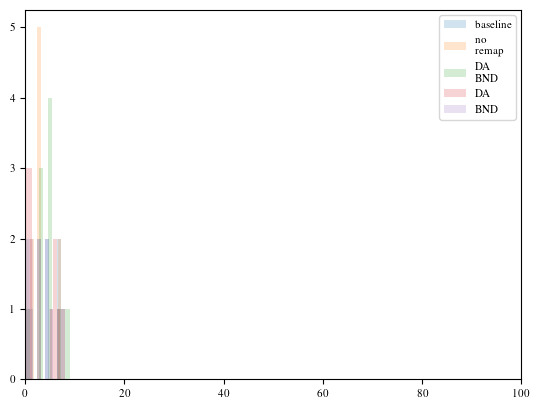

In [70]:
for i in range(5):
    plt.hist(data[:, i], bins=10, alpha=0.2, label=run_options[i])
plt.xlim(0, 100)
plt.legend()
plt.show()

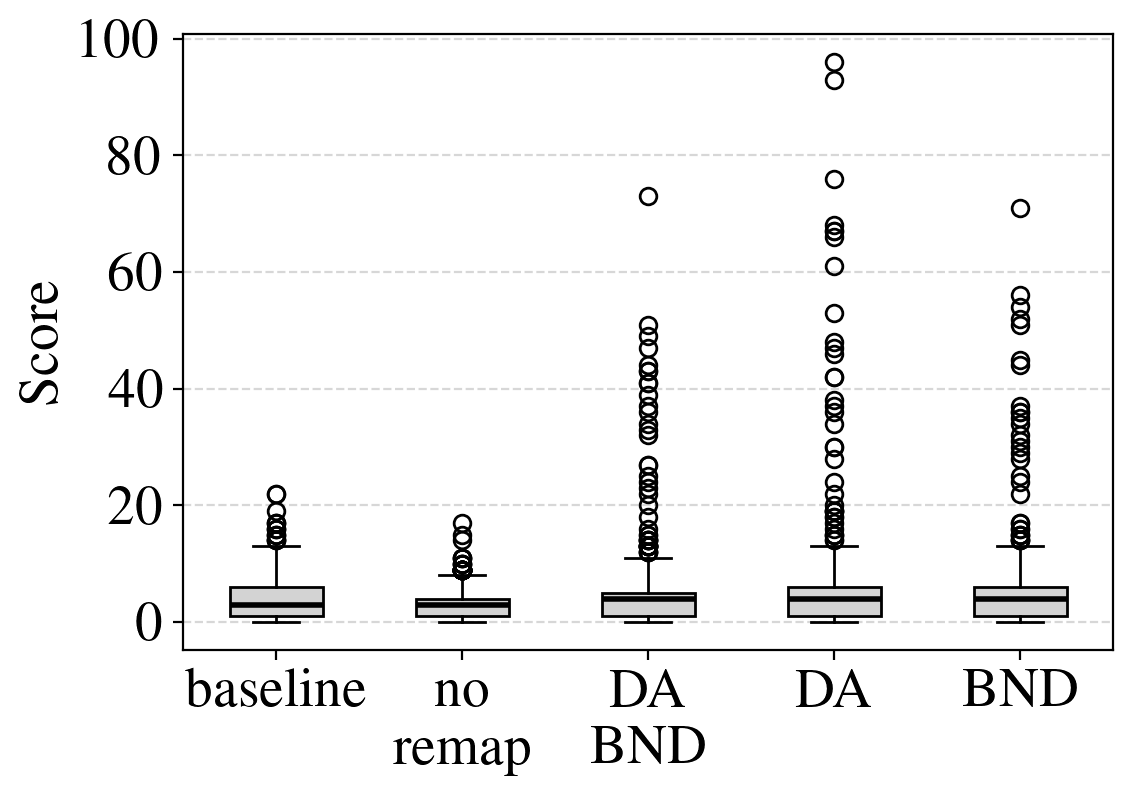

In [52]:
#data = np.array(run['results'])  # Assuming shape (N, 4) where N is number of runs
fontsize = 20
run_options = ["baseline", "no\nremap", "DA\nBND", "DA", "BND"]

# Create box plot
fig = plt.figure(figsize=(6, 4), dpi=200)  # Adjust figure size
plt.boxplot(data, patch_artist=True, 
            boxprops=dict(facecolor="lightgray", color="black"),
            medianprops=dict(color="black", linewidth=2.),
            whiskerprops=dict(color="black", linewidth=1),
            capprops=dict(color="black", linewidth=1))

# Set x-tick labels with fontsize
plt.xticks(range(1, 6), run_options, fontsize=fontsize)  # Boxplot indexes from 1

# Set y-tick labels with fontsize
plt.yticks(fontsize=fontsize)  # This is what you're missing

# Set y-axis label with fontsize
plt.ylabel("Score", fontsize=fontsize)

# Add grid
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Display the plot
plt.show()

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

def calculate_significance_matrix(data, alpha=0.05):
    """
    Calculate statistical significance between all pairs of bars.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Array of shape (N, k) where N is number of samples and k is number of groups/bars
    alpha : float, optional
        Significance level (default: 0.05)
        
    Returns:
    --------
    p_values : numpy.ndarray
        Matrix of p-values for all pairwise comparisons
    significance : numpy.ndarray
        Matrix of boolean values indicating statistical significance
    """
    num_groups = data.shape[1]
    p_values = np.zeros((num_groups, num_groups))
    
    # Calculate p-values for all pairwise comparisons
    for i in range(num_groups):
        for j in range(num_groups):
            if i == j:
                p_values[i, j] = 1.0  # Same group, not significant
            else:
                # Perform independent t-test
                t_stat, p_val = stats.ttest_ind(data[:, i], data[:, j], equal_var=False)
                p_values[i, j] = p_val
    
    # Create significance matrix (True if significant)
    significance = p_values < alpha
    
    return p_values, significance

def plot_significance_matrix(p_values, significance, group_labels=None, figsize=(10, 8)):
    """
    Plot a heatmap of p-values and significance.
    
    Parameters:
    -----------
    p_values : numpy.ndarray
        Matrix of p-values for all pairwise comparisons
    significance : numpy.ndarray
        Matrix of boolean values indicating statistical significance
    group_labels : list, optional
        Labels for the groups/bars
    figsize : tuple, optional
        Figure size for the plot
    """
    num_groups = p_values.shape[0]
    
    if group_labels is None:
        group_labels = [f"Group {i+1}" for i in range(num_groups)]
    
    # Create a mask for non-significant comparisons
    mask = ~significance
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot p-values heatmap
    sns.heatmap(p_values, annot=True, fmt='.3f', cmap='viridis_r', 
                xticklabels=group_labels, yticklabels=group_labels, ax=ax1)
    ax1.set_title('P-values for Pairwise Comparisons')
    
    # Plot significance heatmap
    sns.heatmap(significance.astype(int), annot=True, fmt='d', cmap='RdBu_r',
                xticklabels=group_labels, yticklabels=group_labels, ax=ax2)
    ax2.set_title(f'Statistical Significance ($\\alpha$={alpha})')
    
    #plt.tight_layout()
    return fig

# Example usage with your existing data
def analyze_and_visualize_significance(data, group_labels=None, alpha=0.05):
    """
    Analyze the data and create both a box plot and significance matrix.
    
    Parameters:
    -----------
    data : numpy.ndarray
        Array of shape (N, k) where N is number of samples and k is number of groups/bars
    group_labels : list, optional
        Labels for the groups/bars
    alpha : float, optional
        Significance level (default: 0.05)
    """
    # Calculate significance matrices
    p_values, significance = calculate_significance_matrix(data, alpha)
    
    # Create group labels if not provided
    if group_labels is None:
        group_labels = [f"Group {i+1}" for i in range(data.shape[1])]
    
    # Create a figure with a box plot and significance matrix
    fig = plt.figure(figsize=(15, 10))
    
    # Add box plot
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    box = ax1.boxplot(data, patch_artist=True, 
                boxprops=dict(facecolor="lightgray", color="black"),
                medianprops=dict(color="black", linewidth=1.5),
                whiskerprops=dict(color="black", linewidth=1),
                capprops=dict(color="black", linewidth=1))
    ax1.set_xticklabels(group_labels, fontsize=16)
    ax1.set_ylabel("Score", fontsize=16)
    ax1.tick_params(axis='y', labelsize=16)
    ax1.grid(axis="y", linestyle="--", alpha=0.5)
    ax1.set_title("Box Plot of Scores", fontsize=18)
    
    # Add p-value matrix
    ax2 = plt.subplot2grid((2, 3), (1, 0))
    sns.heatmap(p_values, annot=True, fmt='.3f', cmap='viridis_r', 
                xticklabels=group_labels, yticklabels=group_labels, ax=ax2)
    ax2.set_title('P-values', fontsize=16)
    
    # Add significance matrix
    ax3 = plt.subplot2grid((2, 3), (1, 1))
    sns.heatmap(significance.astype(int), annot=True, fmt='d', cmap='RdBu_r',
                xticklabels=group_labels, yticklabels=group_labels, ax=ax3)
    ax3.set_title(f'Significance ($\\alpha$={alpha})', fontsize=16)
    
    # Add a colorbar explanation for the significance matrix
    ax4 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
    ax4.axis('off')
    ax4.text(0.1, 0.8, "Significance Matrix:", fontsize=16, fontweight='bold')
    ax4.text(0.1, 0.7, "1 (Blue): Statistically significant", fontsize=14)
    ax4.text(0.1, 0.6, "0 (Red): Not significant", fontsize=14)
    ax4.text(0.1, 0.5, f"Significance level: $\\alpha$={alpha}", fontsize=14)
    ax4.text(0.1, 0.4, "Methodology:", fontsize=16, fontweight='bold')
    ax4.text(0.1, 0.3, "Independent t-test with", fontsize=14)
    ax4.text(0.1, 0.2, "unequal variances (Welch's t-test)", fontsize=14)
    
    #plt.tight_layout()
    return fig


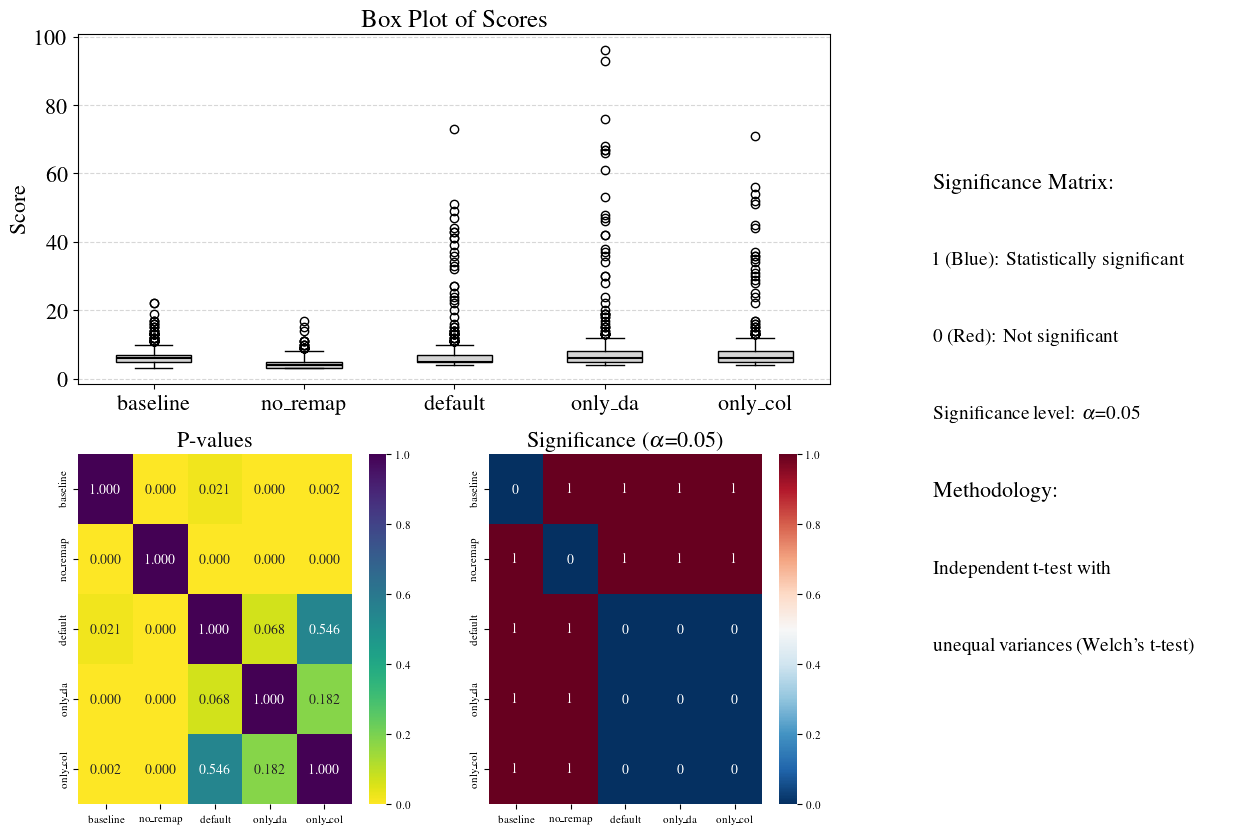

In [30]:
# Example of how to use the function with your data
# data = np.array(run['results'])  # Shape (N, 4) where N is number of runs
group_labels = run['options']
fig = analyze_and_visualize_significance(data, group_labels)
plt.show()

In [16]:
data.shape

(512, 5)

ANOVA F-statistic: 2082.0789, p-value: 0
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj  lower    upper   reject
---------------------------------------------------------
     BND       DA   -8.875   0.0 -12.4006  -5.3494   True
     BND   DA
BND -15.7812   0.0 -19.3069 -12.2556   True
     BND baseline -30.1816   0.0 -33.7073  -26.656   True
     BND no
remap -23.2734   0.0 -26.7991 -19.7478   True
      DA   DA
BND  -6.9062   0.0 -10.4319  -3.3806   True
      DA baseline -21.3066   0.0 -24.8323  -17.781   True
      DA no
remap -14.3984   0.0 -17.9241 -10.8728   True
  DA
BND baseline -14.4004   0.0  -17.926 -10.8748   True
  DA
BND no
remap  -7.4922   0.0 -11.0178  -3.9666   True
baseline no
remap   6.9082   0.0   3.3826  10.4338   True
---------------------------------------------------------


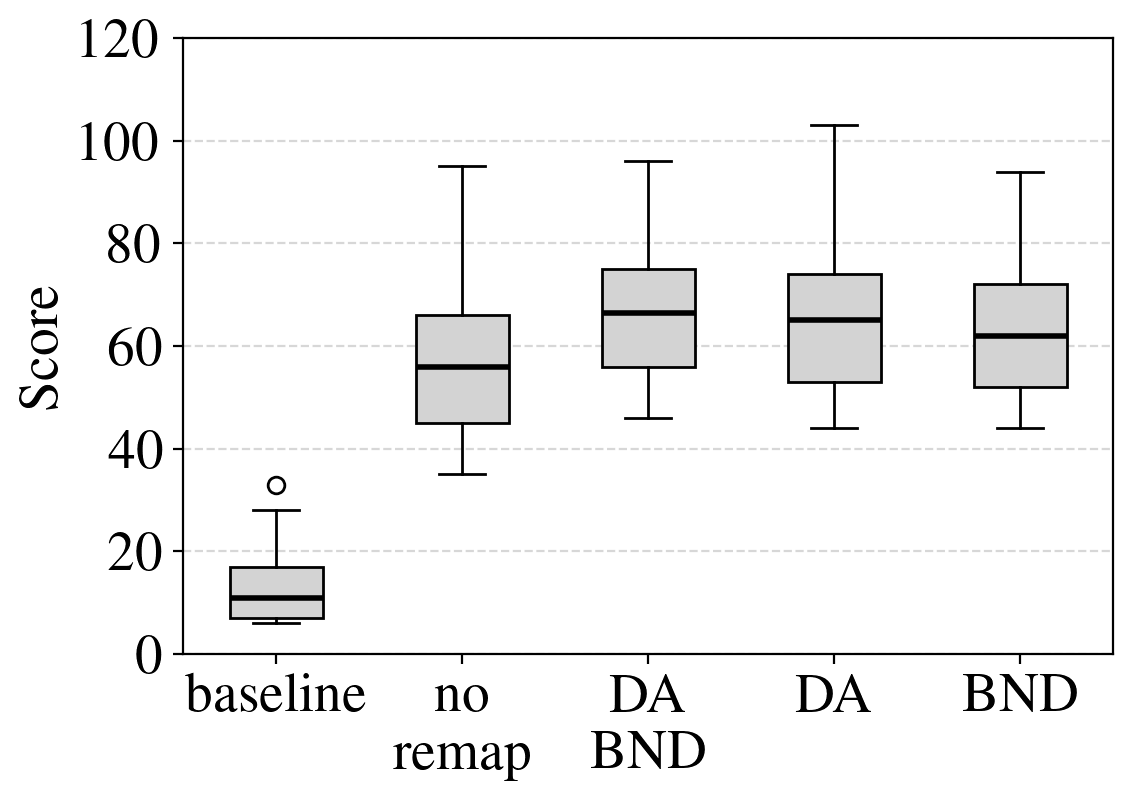

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Your existing code
fontsize = 20
run_options = ["baseline", "no\nremap", "DA\nBND", "DA", "BND"]

# Assuming data shape is (500, 5)
# One-way ANOVA
f_stat, p_val = stats.f_oneway(*[data[:, i] for i in range(data.shape[1])])
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_val:.4g}")

# Tukey HSD Post-hoc test
group_labels = np.array(run_options)
# Flatten data and create corresponding labels
flattened_data = data.flatten()
groups = np.repeat(group_labels, data.shape[0])

tukey = pairwise_tukeyhsd(flattened_data, groups)
print(tukey)

# Box plot
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
box = ax.boxplot(data, patch_artist=True, 
            boxprops=dict(facecolor="lightgray", color="black"),
            medianprops=dict(color="black", linewidth=2.),
            whiskerprops=dict(color="black", linewidth=1),
            capprops=dict(color="black", linewidth=1))

ax.set_xticks(range(1, 6))
ax.set_xticklabels(run_options, fontsize=fontsize)
ax.set_yticks(ax.get_yticks())  # Retain y-ticks
ax.set_yticklabels([f"{int(tick)}" for tick in ax.get_yticks()], fontsize=fontsize)
ax.set_ylabel("Score", fontsize=fontsize)
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Optional: Annotate significance manually from tukey
# You can parse tukey.summary() or tukey.reject to annotate
for i, (reject, pair) in enumerate(zip(tukey.reject, tukey._results_table.data[1:])):
    if reject:
        g1, g2 = pair[0], pair[1]
        idx1 = run_options.index(g1)
        idx2 = run_options.index(g2)
        y = max(np.max(data[:, idx1]), np.max(data[:, idx2])) + 1
        #ax.plot([idx1 + 1, idx2 + 1], [y, y], color='black')
        #ax.text((idx1 + idx2) / 2 + 1, y + 0.2, '*', ha='center', fontsize=fontsize)

plt.show()


In [13]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Pairwise t-tests
p_vals = []
for i in range(data.shape[1]):
    for j in range(i+1, data.shape[1]):
        t_stat, p = ttest_ind(data[:, i], data[:, j])
        p_vals.append((i, j, p))

# Correct for multiple comparisons
p_values = [p[2] for p in p_vals]
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

# Print results
run_options = ('chance', 'noremap', 'BND+DA', 'DA', 'BND')
for (i, j, p), corr_p, r in zip(p_vals, pvals_corrected, reject):
    if not r: continue
    print(f"{run_options[i]} vs {run_options[j]}: raw p = {p:.4g}, corrected p = {corr_p:.4g}, significant: {r}")


chance vs noremap: raw p = 0, corrected p = 0, significant: True
chance vs BND+DA: raw p = 0, corrected p = 0, significant: True
chance vs DA: raw p = 0, corrected p = 0, significant: True
chance vs BND: raw p = 0, corrected p = 0, significant: True
noremap vs BND+DA: raw p = 1.111e-34, corrected p = 1.111e-33, significant: True
noremap vs DA: raw p = 1.827e-24, corrected p = 1.827e-23, significant: True
noremap vs BND: raw p = 2.018e-14, corrected p = 2.018e-13, significant: True
BND+DA vs BND: raw p = 4.645e-07, corrected p = 4.645e-06, significant: True
DA vs BND: raw p = 0.00259, corrected p = 0.0259, significant: True


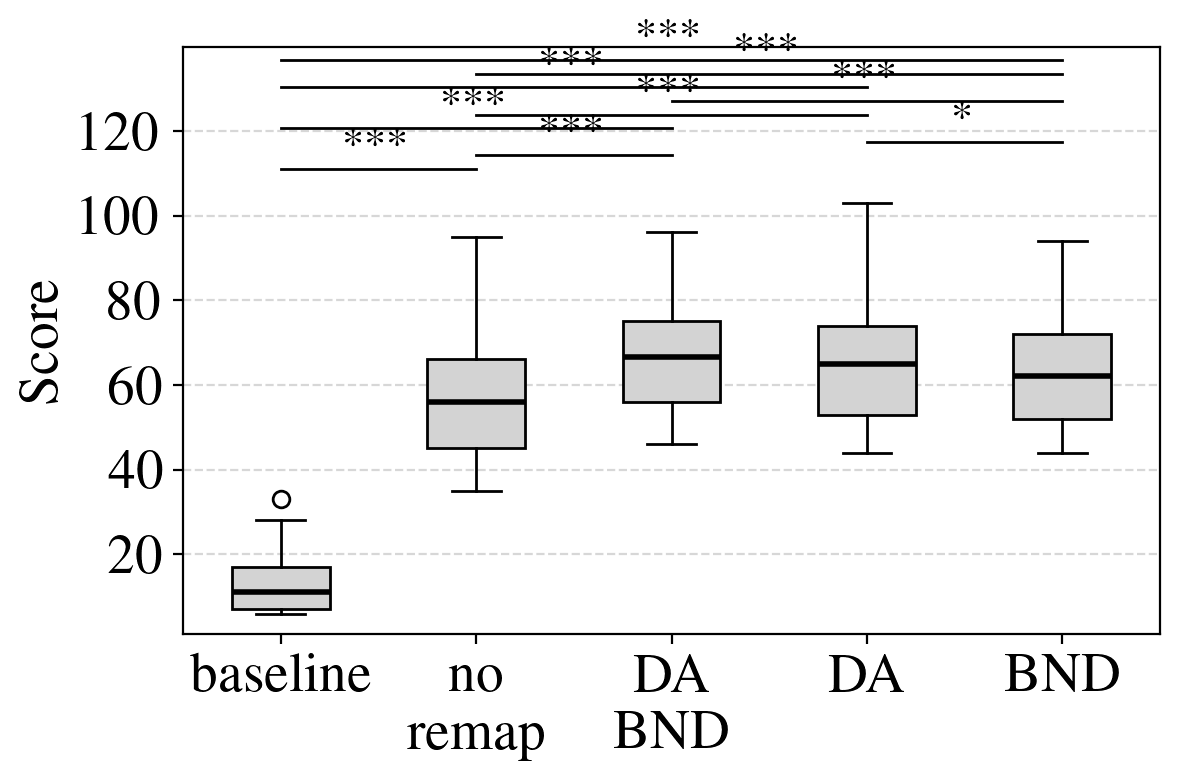

Total comparisons: 10
Significant comparisons: 9


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

# Create boxplot with your original settings
fontsize = 20
run_options = ["baseline", "no\nremap", "DA\nBND", "DA", "BND"]
fig = plt.figure(figsize=(6, 4), dpi=200)
box = plt.boxplot(data, patch_artist=True, 
            boxprops=dict(facecolor="lightgray", color="black"),
            medianprops=dict(color="black", linewidth=2.),
            whiskerprops=dict(color="black", linewidth=1),
            capprops=dict(color="black", linewidth=1))

# Get original y-axis limits before adding significance bars
y_min, y_max = plt.ylim()
plt.ylim(bottom=y_min)  # Keep the original bottom limit

# Perform pairwise t-tests with Bonferroni correction
pairs = list(combinations(range(len(run_options)), 2))
n_comparisons = len(pairs)
alpha = 0.05
alpha_corrected = alpha / n_comparisons

# Store significant pairs
significant_pairs = []
for i, j in pairs:
    t_stat, p_val = stats.ttest_ind(data[:, i], data[:, j], equal_var=False)
    if p_val < alpha_corrected:
        significant_pairs.append((i, j, p_val))

# Sort significant pairs by distance between elements
significant_pairs.sort(key=lambda x: abs(x[0] - x[1]))

# Calculate space for significance bars
bar_space = (y_max - y_min) * 0.03
max_offset = bar_space * (len(significant_pairs) if significant_pairs else 0)

# Set upper limit with just enough space for significance bars
plt.ylim(top=y_max + max_offset + bar_space)

# Add simple significance bars (minimal design)
for idx, (i, j, p) in enumerate(significant_pairs):
    # Convert to 1-indexed positions for the boxplot
    pos1 = i + 1
    pos2 = j + 1
    
    # Height for this bar (stacked based on distance)
    height = y_max + bar_space * (idx + 1)
    
    # Draw a simple line
    plt.plot([pos1, pos2], [height, height], 'k-', linewidth=1.0)
    
    # Add significance indicator (number of stars based on p-value)
    stars = '*' if p < alpha_corrected else ''
    if p < alpha_corrected/10:
        stars = '**'
    if p < alpha_corrected/100:
        stars = '***'
    
    plt.text((pos1 + pos2) / 2, height + bar_space*0.1, stars, 
            ha='center', va='bottom', fontsize=fontsize-4)

# Finish formatting
plt.xticks(range(1, len(run_options) + 1), run_options, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Score", fontsize=fontsize)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Print a simple statistical summary (optional)
print(f"Total comparisons: {n_comparisons}")
print(f"Significant comparisons: {len(significant_pairs)}")